## **Optimizing Cost In Transport Network**

#  Dataset : Washington_road_Network : Weighted

##  Packages Declaration

In [177]:
import numpy as np
import numpy.linalg as lg
import networkx as nx
import matplotlib.pyplot as plt
import scipy as sp
import math as m
import pandas as pd
from collections import Counter
import seaborn as sns
from scipy.linalg import pinv
pic="Washington-road-"


# Dataset Initialization : useful

     source  target    weight
0         0      84  128.9214
1        12      45   45.1298
2        14      58   48.3598
3        15      69   45.1328
4        16      83   41.9087
..      ...     ...       ...
298     189     171  199.0230
299     190      43  115.0566
300     191     176  105.2828
301     191      55  140.6617
302     191     190   91.7260

[303 rows x 3 columns]


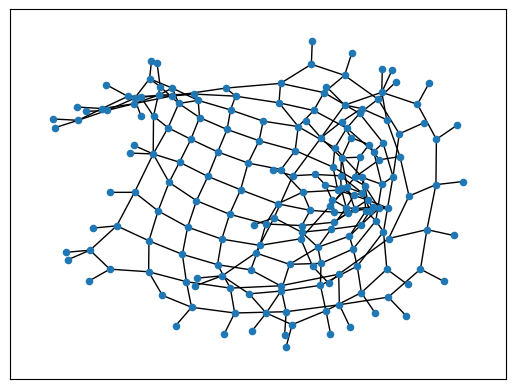

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [120]:
# Loading of our CSV file
df = pd.read_csv('Washington_urban_road_edges.csv')  # Replace with your dataset file
print(df)
# If our csv format has source, target, and weight columns
G = nx.from_pandas_edgelist(df, 'source', 'target')#['weight']
# Extraction of the adjacency matrix
pos=nx.spring_layout(G)
A = nx.to_numpy_array(G)
# Visualize the network
nx.draw_networkx(G, with_labels=False, node_size=20,pos=pos)
plt.axis('on')
plt.savefig(f"{pic}_Structure_of_The_Network.png") 
plt.show()
print(A)

# I. Network Statistics and Distribution

# Node degrees and Number of edges : useful

In [121]:
n = len(A) # nodes
e = np.ones(n)
k = A@e # degrees. @ is a simple way of doing matrix-vector/matrix vector operations
m = np.sum(k)/2 # edges
Lambda, Q = lg.eigh(A)  # eigenvalues of A in Lambda
print(Q)
print(A)
print(np.trace(A@A@A))

[[-0.00468484  0.00731503 -0.00662353 ...  0.01104443 -0.001393
   0.00393349]
 [ 0.01710869 -0.02621724  0.02312953 ...  0.04045798 -0.00531043
   0.01555037]
 [ 0.00736068 -0.00775532 -0.02337532 ... -0.0130564  -0.01324784
   0.03769627]
 ...
 [ 0.08120816  0.05950753 -0.00806722 ...  0.00252834  0.07790956
   0.04273105]
 [ 0.18010948  0.16536406  0.03280155 ...  0.03537001  0.18034242
   0.03701201]
 [ 0.00736723  0.00859476  0.00181006 ...  0.00699841  0.02119782
   0.00247256]]
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
60.0


# Average Degree - Degree distribution

In [122]:
degrees = dict(G.degree())
avg_degree = sum(degrees.values()) / float(G.number_of_nodes())
print(avg_degree)
global_clustering=nx.transitivity(G)  # This is the global clustering coefficient
print(f"Average Degree: {avg_degree}")
print(f"Global Clustering Coefficient: {global_clustering}")

3.1458333333333335
Average Degree: 3.1458333333333335
Global Clustering Coefficient: 0.037037037037037035


# Node degree distribution and accumulated frequency:

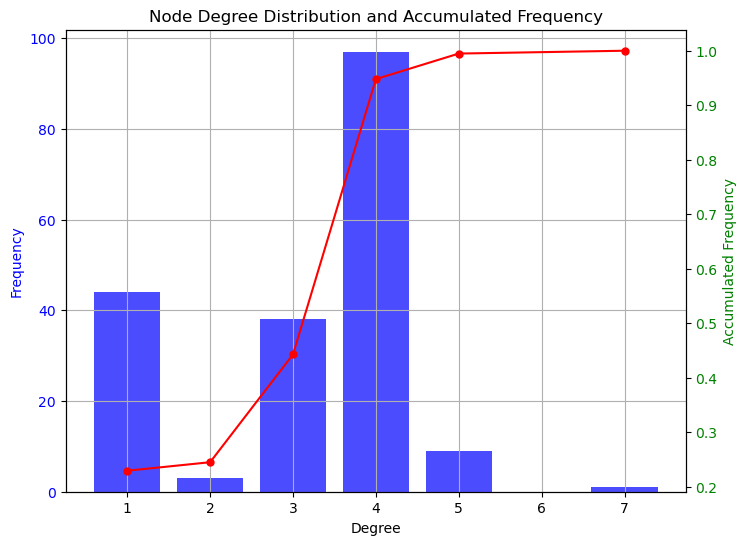

In [123]:

G = nx.from_numpy_array(A)
degrees = [G.degree(n) for n in G.nodes()]

degree_values, degree_counts = np.unique(degrees, return_counts=True)
accumulated_freq = np.cumsum(degree_counts) / sum(degree_counts)

fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.bar(degree_values, degree_counts, color='b', alpha=0.7, label="Degree Frequency", width=0.8)

ax1.set_xlabel("Degree")
ax1.set_ylabel("Frequency", color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()

ax2.plot(degree_values, accumulated_freq, 'ro-', label="Accumulated Frequency", markersize=5)

ax2.set_ylabel("Accumulated Frequency", color='g')
ax2.tick_params(axis='y', labelcolor='g')

ax1.grid(True)

plt.title("Node Degree Distribution and Accumulated Frequency")
plt.savefig('Node_Degree_distribution_And_accumulated_degree_distribution')
plt.show()


# Degree Distribution Of my Network : Useful

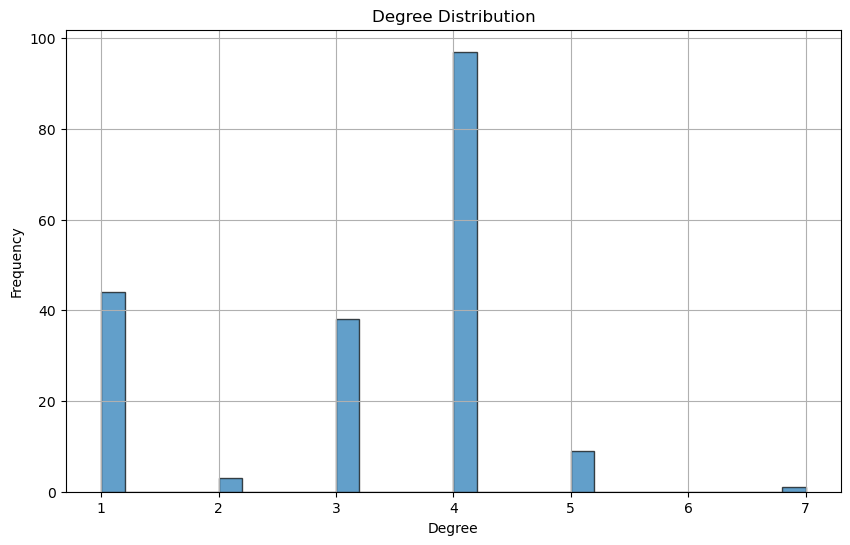

In [124]:
# Compute and plot degree distribution using NetworkX
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
plt.figure(figsize=(10,6))
plt.hist(degree_sequence, bins=30, edgecolor='black', alpha=0.7)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig("Degree_Distribution.png")
plt.show()

# Top Nodes with High degrees in the network

[18, 24, 26, 36, 43, 112, 127, 137, 154, 186, 3, 5, 7, 9, 11, 13, 16, 20, 22, 23]


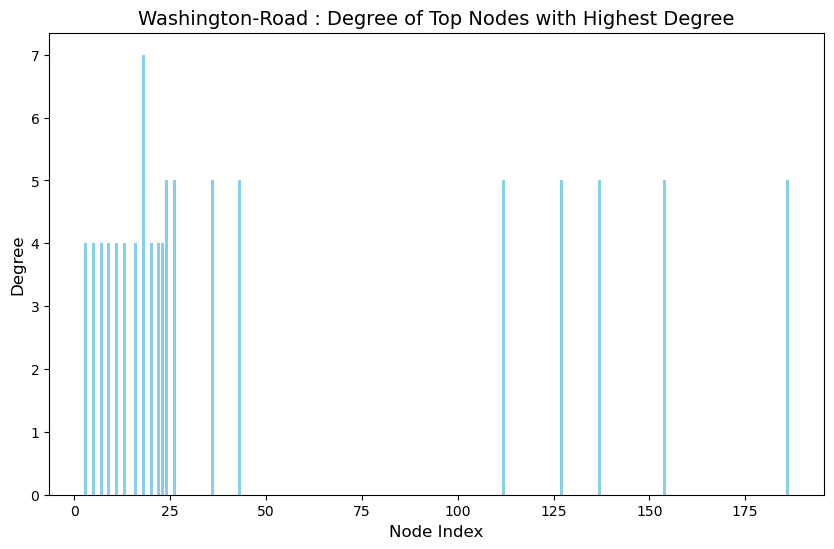

In [180]:
def plot_top_node_degree_histogram(G):
    degree_dict = dict(G.degree())
    top_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)[:20]
    top_node_degrees = [degree_dict[node] for node in top_nodes]
    plt.figure(figsize=(10,6))
    plt.bar(top_nodes, top_node_degrees, color='skyblue')
    plt.xlabel('Node Index', fontsize=12)
    plt.ylabel('Degree', fontsize=12)
    plt.title('Washington-Road : Degree of Top Nodes with Highest Degree', fontsize=14)
    print(top_nodes)
    plt.savefig(f"{pic}Top-node-with-highest-degree-hist")
    plt.show()
    
plot_top_node_degree_histogram(G)

# II.1. Measures of Network distances and Visualisation

# COMPUTE LAPLACIAN MATRIX : USEFUL 

In [126]:
print(f"The number of nodes is :{n}")
print(f"The number of edges is :{m}")
# print(f"The node degrees matrix \nk={k}")
#-------------------Laplacian Matrix----------------------------------
len(A)
KK=np.zeros((len(A),len(A)))
for i in range(len(A)):
    KK[i,i]=k[i]
print(KK) ## KK is a diagonal matrix of the nodes degree 
L=KK-A
print(f"The Laplacien Matrix of the network is \n :{L}")
#-------------------Laplacian Matrix----------------------------------


The number of nodes is :192
The number of edges is :302.0
[[1. 0. 0. ... 0. 0. 0.]
 [0. 3. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 3. 0. 0.]
 [0. 0. 0. ... 0. 4. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
The Laplacien Matrix of the network is 
 :[[ 1. -1.  0. ...  0.  0.  0.]
 [-1.  3.  0. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  3.  0.  0.]
 [ 0.  0.  0. ...  0.  4.  0.]
 [ 0.  0.  0. ...  0.  0.  1.]]


# COMPUTE : RESISTANCE DISTANCE

In [174]:
L_pinv= pinv(L) # To computen the pseudo_inverse of the Laplacian matrix
# print(L_pinv)
R=np.zeros((len(L),len(L)))
for i in range(len(L)):
    for j in range(len(L)):
        R[i,j]=L_pinv[i,i]+L_pinv[j,j]-2*L_pinv[i,j]
print(R)

[[0.         1.         4.13016229 ... 3.12038782 3.13707375 4.78820438]
 [1.         0.         3.13016229 ... 2.12038782 2.13707375 3.78820438]
 [4.13016229 3.13016229 0.         ... 2.49430039 2.5663733  4.26316196]
 ...
 [3.12038782 2.12038782 2.49430039 ... 0.         0.8349915  2.65032372]
 [3.13707375 2.13707375 2.5663733  ... 0.8349915  0.         2.26910775]
 [4.78820438 3.78820438 4.26316196 ... 2.65032372 2.26910775 0.        ]]


# COMPUTE : CHEBOTAREV-SHAMIS-METRIC

In [175]:
#let's define alpha
alpha=250000000 
I=np.eye(len(L))
print(I)
#Let's define Q=(I-alpha*L)^-1
Q=lg.inv(I-alpha*L)
print(Q)

CS=np.zeros((len(Q),len(Q)))
for i in range(len(Q)):
    for j in range(len(Q)):
        CS[i,j]=0.5*(Q[i,i]+Q[j,j]-Q[i,j]-Q[j,i])
print(f"The chebotarev-shamis metric is given by\n:{CS}")

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
[[0.00520832 0.00520833 0.00520833 ... 0.00520833 0.00520833 0.00520833]
 [0.00520833 0.00520833 0.00520833 ... 0.00520833 0.00520833 0.00520833]
 [0.00520833 0.00520833 0.00520833 ... 0.00520833 0.00520833 0.00520833]
 ...
 [0.00520833 0.00520833 0.00520833 ... 0.00520833 0.00520833 0.00520833]
 [0.00520833 0.00520833 0.00520833 ... 0.00520833 0.00520833 0.00520833]
 [0.00520833 0.00520833 0.00520833 ... 0.00520833 0.00520833 0.00520833]]
The chebotarev-shamis metric is given by
:[[ 0.00000000e+00 -2.00000001e-09 -8.26032476e-09 ... -6.24077581e-09
  -6.27414771e-09 -9.57640907e-09]
 [-2.00000001e-09  0.00000000e+00 -6.26032473e-09 ... -4.24077577e-09
  -4.27414768e-09 -7.57640903e-09]
 [-8.26032476e-09 -6.26032473e-09  0.00000000e+00 ... -4.98860088e-09
  -5.13274675e-09 -8.52632417e-09]
 ...
 [-6.24077581e-09 -4.24077577e-09 -4.9

# Scaled Metric :

In [176]:
def scaled_metric(M):
    M_min = np.min(M)
    M_max = np.max(M)
    M_scaled = (M - M_min) / (M_max - M_min)
    return M_scaled

CS_scaled=scaled_metric(CS) # scaled Chebotarev-SHamis metric 
R_scaled=scaled_metric(R) # Scaled resistance  Metric
print("THe scaled Chebotarev-SHamis-Metric is \n\n: ")
print(CS_scaled)
print("THe scaled Resistance DIstance Metric is \n\n : ")
print(R_scaled)

THe scaled Chebotarev-SHamis-Metric is 

: 
[[1.         0.82101902 0.2607795  ... 0.44150992 0.43852346 0.14300247]
 [0.82101902 1.         0.43976048 ... 0.6204909  0.61750444 0.32198345]
 [0.2607795  0.43976048 1.         ... 0.55356767 0.54066799 0.23697508]
 ...
 [0.44150992 0.6204909  0.55356767 ... 1.         0.8505524  0.52564246]
 [0.43852346 0.61750444 0.54066799 ... 0.8505524  1.         0.59387287]
 [0.14300247 0.32198345 0.23697508 ... 0.52564246 0.59387287 1.        ]]
THe scaled Resistance DIstance Metric is 

 : 
[[0.         0.17898099 0.73922052 ... 0.55849009 0.56147655 0.85699754]
 [0.17898099 0.         0.56023953 ... 0.3795091  0.38249557 0.67801656]
 [0.73922052 0.56023953 0.         ... 0.44643234 0.45933202 0.76302493]
 ...
 [0.55849009 0.3795091  0.44643234 ... 0.         0.1494476  0.47435755]
 [0.56147655 0.38249557 0.45933202 ... 0.1494476  0.         0.40612714]
 [0.85699754 0.67801656 0.76302493 ... 0.47435755 0.40612714 0.        ]]


# Heatmap : Resistance Distance Metric

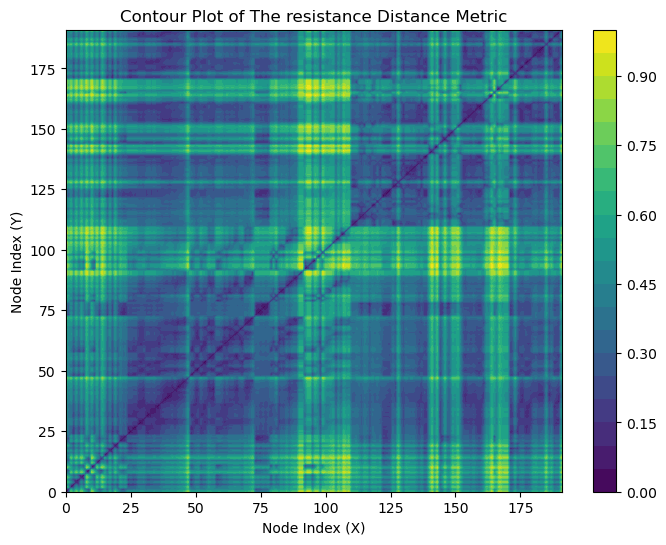

In [178]:
x = np.arange(R_scaled.shape[0])
y = np.arange(R_scaled.shape[1])
X, Y = np.meshgrid(x, y)
# Create the contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, R_scaled, levels=20, cmap='viridis')  # 20 levels, or adjust as needed
plt.colorbar(contour)  # Add a colorbar to show the scale
# Set labels and title
plt.title('Contour Plot of The resistance Distance Metric')
plt.xlabel('Node Index (X)')
plt.ylabel('Node Index (Y)')
# Display the plot
plt.savefig(f"{pic}resistance-distance-heatmap")
plt.show()

# Heatmap : Chebotarev-Shamis Metric 

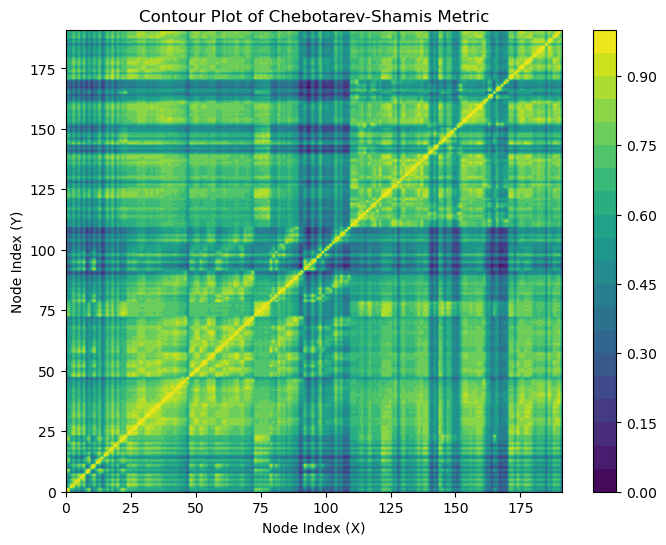

In [182]:
x = np.arange(CS_scaled.shape[0])
y = np.arange(CS_scaled.shape[1])
X, Y = np.meshgrid(x, y)
# Create the contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, CS_scaled, levels=20, cmap='viridis')  # 20 levels, or adjust as needed
plt.colorbar(contour)  # Add a colorbar to show the scale
# Set labels and title
plt.title('Contour Plot of Chebotarev-Shamis Metric')
plt.xlabel('Node Index (X)')
plt.ylabel('Node Index (Y)')
# Display the plot
plt.savefig(f"{pic}Chebotarev-shamis-heatmap")

plt.show()

In [132]:
len(D_sp)
print(D_sp[0,:])
D_co2=A

[ 0.  1.  8.  7.  9.  8. 10.  9.  3.  2. 11. 10.  4.  3.  3.  5.  4.  6.
  5.  7.  6.  3.  2.  4.  7.  6.  8.  8. 12. 12. 13.  9.  9. 10. 10. 11.
 11. 12. 14. 13. 12. 14. 14. 15. 15. 14. 15. 15.  8. 10. 13. 14.  9. 11.
 12. 16. 15. 14.  9. 10. 11. 13. 12. 15. 14. 16. 15. 15. 13. 17. 16. 17.
 16.  3.  3.  4.  4.  5.  5. 10. 13. 11. 14. 16. 15. 17. 16. 18. 17. 18.
 17. 17. 11. 12. 12. 11. 12. 14. 14. 12. 15. 16. 17. 18. 17. 18. 19. 20.
 19. 19. 10. 11. 11.  7.  6.  8.  7.  6.  8.  9.  8. 10.  4.  5.  6.  7.
 12. 12. 13. 12.  8. 11. 12. 10. 11.  9.  8. 11.  6.  7.  9. 10.  8.  9.
  7.  5.  6.  6.  7.  8.  7.  9.  9. 10. 11. 10.  9. 11. 10.  8.  9. 13.
 13. 11. 12.  5. 10. 11. 10. 12. 12.  5.  6.  6.  7. 11. 12.  8.  9. 10.
 13. 14. 12. 13. 12. 14. 13. 14. 10. 11. 13. 15.]


# II. Communicability Distance Metric

In [183]:
B=sp.linalg.expm(A)#compute the communicability Matrix Function
print(B)
print(np.shape(B))

[[1.64891432e+00 1.64984729e+00 5.51103253e-05 ... 1.53642945e-06
  6.34457115e-08 2.62972594e-11]
 [1.64984729e+00 3.30218770e+00 4.98469038e-04 ... 1.80714265e-05
  8.58518240e-07 4.14834204e-10]
 [5.51103253e-05 4.98469038e-04 1.71931480e+00 ... 1.10179727e-04
  2.70058109e-06 1.45568095e-10]
 ...
 [1.53642945e-06 1.80714265e-05 1.10179727e-04 ... 3.70787706e+00
  1.35107021e+00 2.58044734e-03]
 [6.34457115e-08 8.58518240e-07 2.70058109e-06 ... 1.35107021e+00
  5.19712861e+00 8.20557769e-02]
 [2.62972594e-11 4.14834204e-10 1.45568095e-10 ... 2.58044734e-03
  8.20557769e-02 1.65343166e+00]]
(192, 192)


[[0.         1.65140744 3.3681189  ... 5.3567883  6.8460428  3.30234598]
 [1.65140744 0.         5.02050556 ... 7.01002861 8.49931459 4.95561936]
 [3.3681189  5.02050556 0.         ... 5.42697149 6.91643801 3.37274646]
 ...
 [5.3567883  7.01002861 5.42697149 ... 0.         6.20286525 5.35614782]
 [6.8460428  8.49931459 6.91643801 ... 6.20286525 0.         6.68644872]
 [3.30234598 4.95561936 3.37274646 ... 5.35614782 6.68644872 0.        ]]
[[1.64891432e+00 1.64984729e+00 5.51103253e-05 ... 1.53642945e-06
  6.34457115e-08 2.62972594e-11]
 [1.64984729e+00 3.30218770e+00 4.98469038e-04 ... 1.80714265e-05
  8.58518240e-07 4.14834204e-10]
 [5.51103253e-05 4.98469038e-04 1.71931480e+00 ... 1.10179727e-04
  2.70058109e-06 1.45568095e-10]
 ...
 [1.53642945e-06 1.80714265e-05 1.10179727e-04 ... 3.70787706e+00
  1.35107021e+00 2.58044734e-03]
 [6.34457115e-08 8.58518240e-07 2.70058109e-06 ... 1.35107021e+00
  5.19712861e+00 8.20557769e-02]
 [2.62972594e-11 4.14834204e-10 1.45568095e-10 ... 2.580

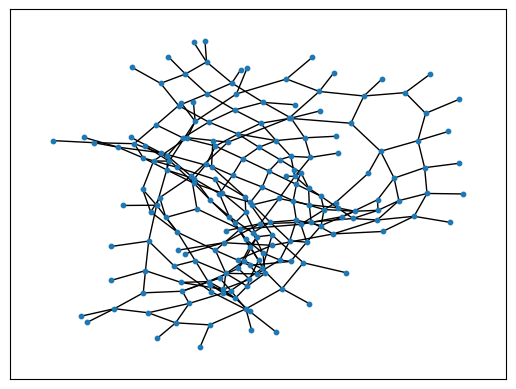

(192,)


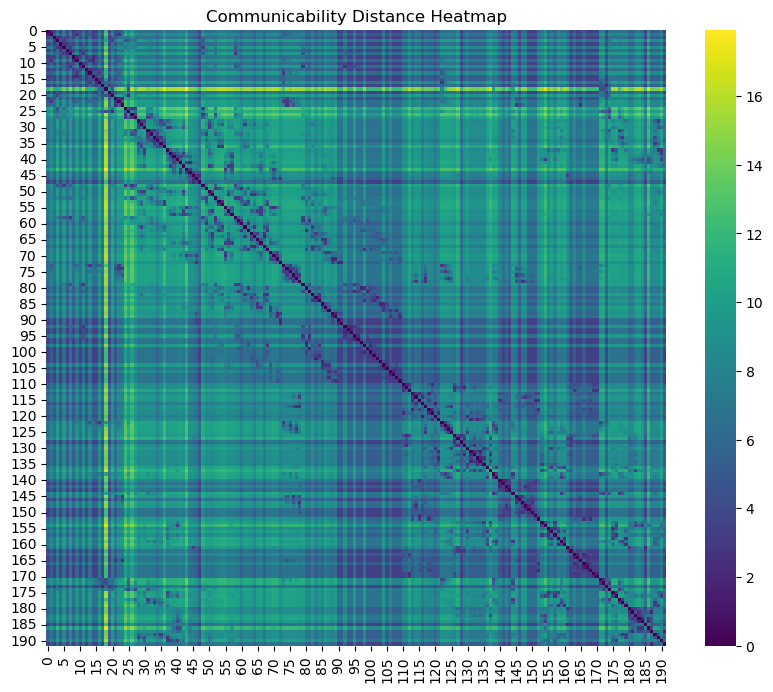

In [194]:
D=np.zeros((len(B),len(B)))
for i in range(len(B)):
    for j in range(len(B)):
        D[i,j]=B[i,i]+B[j,j]-2*B[i,j]
print(D) # D is the communicability matrix of the graph 
print(B)
C=A*D# is the communicability distance matrix
print(C)
G1=nx.from_numpy_array(C)
nx.draw_networkx(G1,with_labels=False,node_size=10)
plt.savefig(f"{pic}Communicability_Structure_of_The_Network.png") 
plt.show()
print(np.shape(G1))
# Heatmap for communicability distance matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(D, cmap='viridis')#'viridis' #"YlGnBu"
plt.title("Communicability Distance Heatmap")
plt.savefig(f"{pic}Communicability_Distance_Heatmap.png")
plt.show()

In [135]:
# print(dict(nx.floyd_warshall(G1)))

In [187]:
print(G1.number_of_edges(),G.number_of_edges())  # To check the number of edges of each Graph

302 302


In [188]:
source_node = 1  #  We can always change the source node
# shortest_paths_dijkstra = nx.single_source_dijkstra_path_length(G1, source=source_node, weight='weight')
#-------------------------------------------------------------------------------------------------------
#This code below is generating the communicability shortest distance 
shortest_paths_dijkstra1 = nx.shortest_path(G1, source=source_node, weight='weight')
# print(shortest_paths_dijkstra1)
# print("Shortest paths using Dijkstra’s algorithm:", shortest_paths_dijkstra1)
#-------------------------------------------------------------------------------------------------------
# We can easily see that by computing the above code the dictionnary keys are not sorted
#---------------------------------dictionary key sorting attempts--------------------------------------------------------------------
Cpq=list( shortest_paths_dijkstra1.keys() )
Cpq.sort()
# print(Cpq)
Sorted_Cpq={i:shortest_paths_dijkstra1[i] for i in Cpq} # 
print(Sorted_Cpq)
#-------------------------------------------------------------------------------------------------------

{0: [1, 0], 1: [1], 2: [1, 9, 13, 16, 18, 20, 3, 2], 3: [1, 9, 13, 16, 18, 20, 3], 4: [1, 9, 13, 16, 18, 20, 3, 5, 4], 5: [1, 9, 13, 16, 18, 20, 3, 5], 6: [1, 9, 13, 16, 18, 20, 3, 5, 7, 6], 7: [1, 9, 13, 16, 18, 20, 3, 5, 7], 8: [1, 9, 8], 9: [1, 9], 10: [1, 9, 13, 16, 18, 20, 3, 5, 7, 11, 10], 11: [1, 9, 13, 16, 18, 20, 3, 5, 7, 11], 12: [1, 9, 13, 12], 13: [1, 9, 13], 14: [1, 9, 14], 15: [1, 9, 13, 16, 15], 16: [1, 9, 13, 16], 17: [1, 9, 13, 16, 18, 17], 18: [1, 9, 13, 16, 18], 19: [1, 9, 13, 16, 18, 20, 19], 20: [1, 9, 13, 16, 18, 20], 21: [1, 22, 21], 22: [1, 22], 23: [1, 22, 21, 23], 24: [1, 9, 13, 16, 18, 25, 24], 25: [1, 9, 13, 16, 18, 25], 26: [1, 22, 73, 122, 171, 172, 174, 27, 26], 27: [1, 22, 73, 122, 171, 172, 174, 27], 28: [1, 22, 74, 75, 77, 117, 125, 136, 160, 179, 189, 28], 29: [1, 22, 74, 75, 77, 117, 125, 136, 160, 179, 189, 28, 29], 30: [1, 22, 74, 75, 77, 117, 125, 136, 156, 155, 175, 37, 30], 31: [1, 22, 74, 75, 123, 138, 144, 177, 31], 32: [1, 22, 74, 75, 123, 13

In [189]:
shortest_paths_dijkstra2 = nx.shortest_path(G, source=source_node, weight='weight')
#shortest unweighted graph # Normal graph shortest path
#----------------------------------------------------------------------------
# print(shortest_paths_dijkstra2) // to print the unsorted one 
#----------------------------------------------------------------------------
#That uses the regular distance, This one is also not sorted 
Dpq=list( shortest_paths_dijkstra2.keys() )
Dpq.sort()
# print(Dpq)
Sorted_Dpq={i:shortest_paths_dijkstra2[i] for i in Dpq}
print(Sorted_Dpq)
                   

{0: [1, 0], 1: [1], 2: [1, 9, 13, 16, 18, 20, 3, 2], 3: [1, 9, 13, 16, 18, 20, 3], 4: [1, 9, 13, 16, 18, 20, 3, 5, 4], 5: [1, 9, 13, 16, 18, 20, 3, 5], 6: [1, 9, 13, 16, 18, 20, 3, 5, 7, 6], 7: [1, 9, 13, 16, 18, 20, 3, 5, 7], 8: [1, 9, 8], 9: [1, 9], 10: [1, 9, 13, 16, 18, 20, 3, 5, 7, 11, 10], 11: [1, 9, 13, 16, 18, 20, 3, 5, 7, 11], 12: [1, 9, 13, 12], 13: [1, 9, 13], 14: [1, 9, 14], 15: [1, 9, 13, 16, 15], 16: [1, 9, 13, 16], 17: [1, 9, 13, 16, 18, 17], 18: [1, 9, 13, 16, 18], 19: [1, 9, 13, 16, 18, 20, 19], 20: [1, 9, 13, 16, 18, 20], 21: [1, 22, 21], 22: [1, 22], 23: [1, 22, 21, 23], 24: [1, 9, 13, 16, 18, 25, 24], 25: [1, 9, 13, 16, 18, 25], 26: [1, 9, 13, 16, 18, 25, 24, 26], 27: [1, 9, 13, 16, 18, 25, 24, 27], 28: [1, 9, 13, 16, 18, 25, 24, 27, 31, 33, 35, 28], 29: [1, 9, 13, 16, 18, 25, 24, 26, 32, 34, 36, 29], 30: [1, 9, 13, 16, 18, 25, 24, 27, 31, 33, 35, 28, 30], 31: [1, 9, 13, 16, 18, 25, 24, 27, 31], 32: [1, 9, 13, 16, 18, 25, 24, 26, 32], 33: [1, 9, 13, 16, 18, 25, 24, 

In [190]:
len(Sorted_Cpq)==len(Sorted_Dpq)
A1=Sorted_Cpq.keys()
# print(A1)
A2=Sorted_Dpq.keys()
# print(A2)
A1==A2
A1_values=Sorted_Cpq.values() # shortest regular distance path
# Now my task is to sort the keys of both the dictionnaries :
# print(A1_values)
A2_values=Sorted_Dpq.values() #shortest communicability path 
# print(list(A2_values))
A1_values==A2_values
A22=[len(i) for i in list(A2_values)]
# print(A22)
A11=[len(i) for i in list(A1_values)] # It is the list of the paths lengths in Cpq_values ie associated to a given node
print(len(A11))

192


In [191]:
indx=[]
for i in range(len(A11)):
    if A11[i]!=A22[i] :
        indx.append(i)
print(len(indx))
comp=[]
CpqA11=[] #

DpqA22=[]
#creating now list that stores values when com_SP>Regularshortest(or else) and when they are equal
Cpq_great=[]
Cpq_eq_Sp=[]
for i in indx :
    CpqA11.append(A11[i])# communicability distance for the indices where Cpq differ from Dpq 
    DpqA22.append(A22[i])# regular shortest path the indices where Cpq differ from Dpq
    comp.append((A11[i],A22[i]))
print(len(DpqA22))
# print(comp)
#creating now list that stores values when com_SP>Regularshortest(or else) and when they are equal
Cpq_great=[]
Spq_great=[]
Cpq_eq_Sp=[]
for i in range(len(A11)):
    if A11[i]>A22[i]:
        Cpq_great.append(A11[i])
    elif A11[i]<A22[i]:
        Spq_great.append(A22[i])
    else :
        Cpq_eq_Sp.append(A11[i])
print( len(Cpq_great),len(Cpq_eq_Sp) )


53
53
53 139


# Plot pie chart showing differences in Proportion

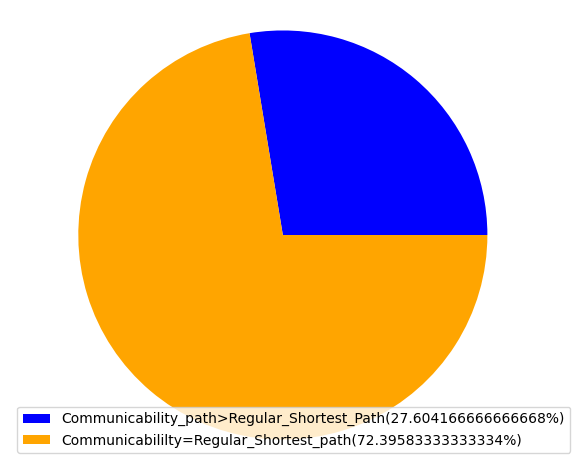

In [192]:
# The slices will be ordered and plotted counter-clockwise.
P1=(len(Cpq_great)/len(A11))*100
P2=(len(Cpq_eq_Sp)/len(A11))*100
labels = [f'Communicability_path>Regular_Shortest_Path({P1}%)', f'Communicabililty=Regular_Shortest_path({P2}%)']
sizes = [P1,P2]
colors = ['blue', 'orange']
patches, texts = plt.pie(sizes, colors=colors, startangle=0)
plt.legend(patches, labels,loc='best')
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.tight_layout()
plt.savefig(f"Shorest_path_comparison_chart_{pic}.png")
plt.show()

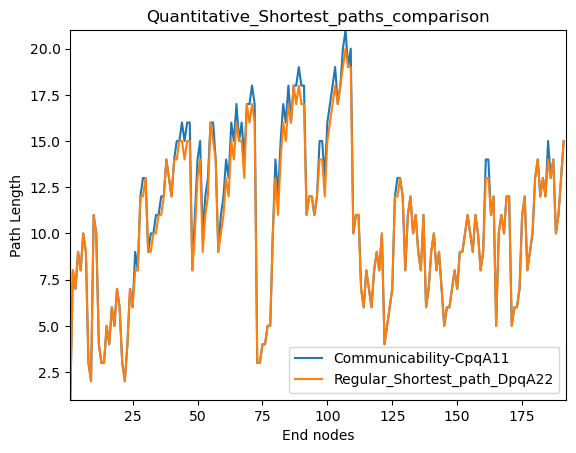

In [225]:
plt.plot(range(len(A11)), A11, label = "Communicability-CpqA11")
plt.plot(range(len(A11)), A22, label = "Regular_Shortest_path_DpqA22")
plt.xlim(1,len(A11))
plt.ylim(1,max(A11))
plt.xlabel('End nodes')
plt.ylabel('Path Length')
plt.title('Quantitative_Shortest_paths_comparison')
plt.legend()
plt.savefig(f"{pic}Quantitative_Shorest_paths_comparison_Plot.png")
plt.show()
# A11


# CONTOUR  Plot Of  Communicability Distance Matrix

In [223]:
# x = np.arange(D.shape[0])
# y = np.arange(D.shape[1])
# X, Y = np.meshgrid(x, y)
# # Create the contour plot
# plt.figure(figsize=(8, 6))
# contour = plt.contourf(X, Y, D, levels=20, cmap='viridis') # 20 levels, or adjust as needed
# plt.colorbar(contour)  # Add a colorbar to show the scale
# # Set labels and title
# plt.title('Contour Plot of Communicability Distance Matrix')
# plt.xlabel('Node Index (X)')
# plt.ylabel('Node Index (Y)')
# # Display the plot
# plt.show()
A11 # number of path
# # Pay attention this 2nd contour plot is exactly the same as the first one . cmap : is the only change

[2,
 1,
 8,
 7,
 9,
 8,
 10,
 9,
 3,
 2,
 11,
 10,
 4,
 3,
 3,
 5,
 4,
 6,
 5,
 7,
 6,
 3,
 2,
 4,
 7,
 6,
 9,
 8,
 12,
 13,
 13,
 9,
 10,
 10,
 11,
 11,
 12,
 12,
 14,
 13,
 12,
 14,
 15,
 15,
 16,
 15,
 16,
 16,
 8,
 11,
 14,
 15,
 10,
 12,
 13,
 16,
 16,
 14,
 9,
 11,
 12,
 14,
 13,
 16,
 15,
 17,
 15,
 16,
 14,
 17,
 17,
 18,
 17,
 3,
 3,
 4,
 4,
 5,
 5,
 10,
 14,
 12,
 15,
 17,
 16,
 18,
 16,
 18,
 18,
 19,
 18,
 18,
 11,
 12,
 12,
 11,
 12,
 15,
 15,
 13,
 16,
 17,
 18,
 19,
 17,
 18,
 20,
 21,
 19,
 20,
 10,
 11,
 11,
 7,
 6,
 8,
 7,
 6,
 8,
 9,
 8,
 10,
 4,
 5,
 6,
 7,
 12,
 13,
 13,
 12,
 8,
 11,
 12,
 10,
 11,
 9,
 8,
 11,
 6,
 7,
 9,
 10,
 8,
 9,
 7,
 5,
 6,
 6,
 7,
 8,
 7,
 9,
 9,
 10,
 11,
 10,
 9,
 11,
 10,
 8,
 9,
 14,
 14,
 11,
 12,
 5,
 10,
 11,
 10,
 12,
 12,
 5,
 6,
 6,
 7,
 11,
 12,
 8,
 9,
 10,
 13,
 14,
 12,
 13,
 12,
 15,
 13,
 14,
 10,
 11,
 13,
 15]

In [199]:
Sorted_Dpq

{0: [1, 0],
 1: [1],
 2: [1, 9, 13, 16, 18, 20, 3, 2],
 3: [1, 9, 13, 16, 18, 20, 3],
 4: [1, 9, 13, 16, 18, 20, 3, 5, 4],
 5: [1, 9, 13, 16, 18, 20, 3, 5],
 6: [1, 9, 13, 16, 18, 20, 3, 5, 7, 6],
 7: [1, 9, 13, 16, 18, 20, 3, 5, 7],
 8: [1, 9, 8],
 9: [1, 9],
 10: [1, 9, 13, 16, 18, 20, 3, 5, 7, 11, 10],
 11: [1, 9, 13, 16, 18, 20, 3, 5, 7, 11],
 12: [1, 9, 13, 12],
 13: [1, 9, 13],
 14: [1, 9, 14],
 15: [1, 9, 13, 16, 15],
 16: [1, 9, 13, 16],
 17: [1, 9, 13, 16, 18, 17],
 18: [1, 9, 13, 16, 18],
 19: [1, 9, 13, 16, 18, 20, 19],
 20: [1, 9, 13, 16, 18, 20],
 21: [1, 22, 21],
 22: [1, 22],
 23: [1, 22, 21, 23],
 24: [1, 9, 13, 16, 18, 25, 24],
 25: [1, 9, 13, 16, 18, 25],
 26: [1, 9, 13, 16, 18, 25, 24, 26],
 27: [1, 9, 13, 16, 18, 25, 24, 27],
 28: [1, 9, 13, 16, 18, 25, 24, 27, 31, 33, 35, 28],
 29: [1, 9, 13, 16, 18, 25, 24, 26, 32, 34, 36, 29],
 30: [1, 9, 13, 16, 18, 25, 24, 27, 31, 33, 35, 28, 30],
 31: [1, 9, 13, 16, 18, 25, 24, 27, 31],
 32: [1, 9, 13, 16, 18, 25, 24, 26, 32],

# III Test and Implement Hybrid Measure of Network Distance 


\begin{equation}
H_{pq}=\alpha d_{pq} +\beta d_{co_2}(p,q) +\gamma C_{pq}
\end{equation}


In [200]:
def floyd_warshall_shortest_paths_from_edgelist(G):
    # Compute shortest path lengths between all pairs of nodes using Floyd-Warshall
    shortest_paths = dict(nx.floyd_warshall(G))
    # Get all nodes in the graph
    nodes = list(G.nodes())
    num_nodes = len(nodes)
    # Initialize the shortest path matrix with zeros
    sp_matrix = np.full((num_nodes, num_nodes), np.inf)
    print(sp_matrix)
    # Fill the matrix with the computed shortest paths
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            sp_matrix[i, j] = shortest_paths[u][v]
    return sp_matrix, nodes
# Compute shortest paths from the edge list
shortest_paths_matrix, nodes =floyd_warshall_shortest_paths_from_edgelist(G)
# Display the result
nodes.sort()
print("Nodes:", nodes)
print("Shortest Path Matrix:")
D_sp=shortest_paths_matrix
print(shortest_paths_matrix)

[[inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]
 ...
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]]
Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 


In order to be able to sum up all the three metric, we need to normalize them so that their values lies between \[0-1\]. Hence Our Normalized novel metric is now defined as :
\begin{equation}
H_{pq}=\alpha\frac{d_{sp}}{max(d_{sp})} +\gamma\frac{d_{co2}}{max(d_{Co2})}+\gamma\frac{C_{pq}}{max(C_{pq})}
\end{equation}


[[ 0.  1.  8. ... 11. 13. 15.]
 [ 1.  0.  7. ... 10. 12. 14.]
 [ 8.  7.  0. ...  8. 10. 14.]
 ...
 [11. 10.  8. ...  0.  2.  6.]
 [13. 12. 10. ...  2.  0.  4.]
 [15. 14. 14. ...  6.  4.  0.]]
[[0.         1.65140744 0.         ... 0.         0.         0.        ]
 [1.65140744 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Testing for : alpha=0.3, beta=0.1, gamma=0.5


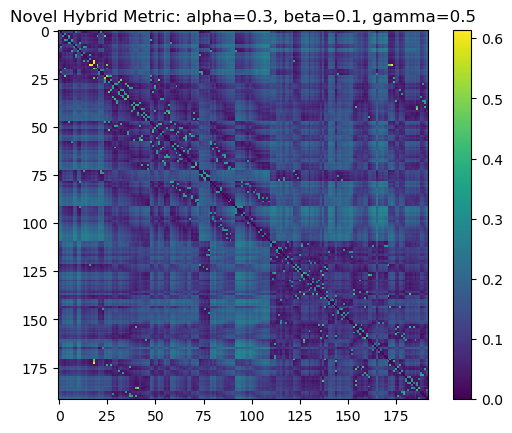

Testing for : alpha=0.3, beta=0.1, gamma=0.7


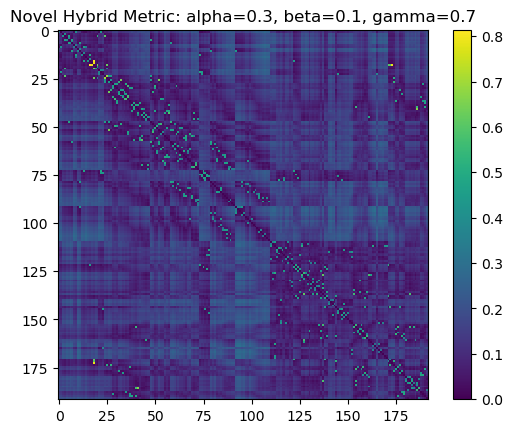

Testing for : alpha=0.3, beta=0.1, gamma=0.9


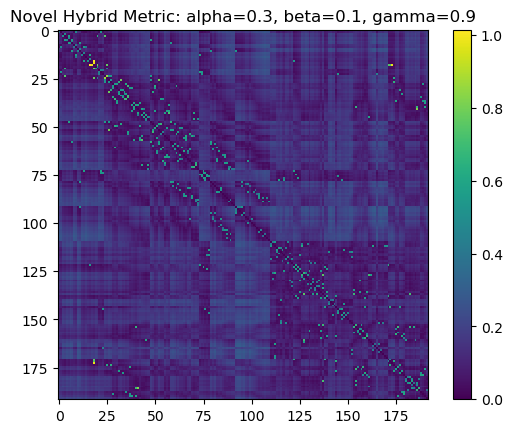

Testing for : alpha=0.3, beta=0.3, gamma=0.5


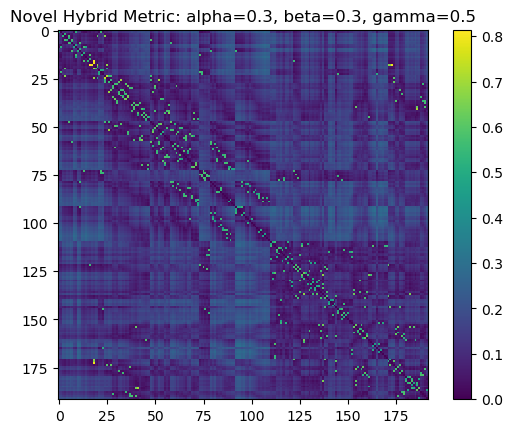

Testing for : alpha=0.3, beta=0.3, gamma=0.7


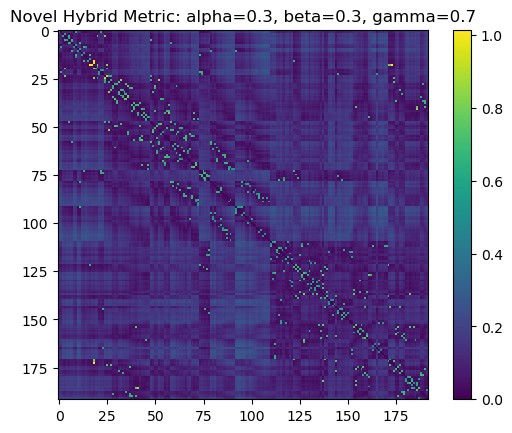

Testing for : alpha=0.3, beta=0.3, gamma=0.9


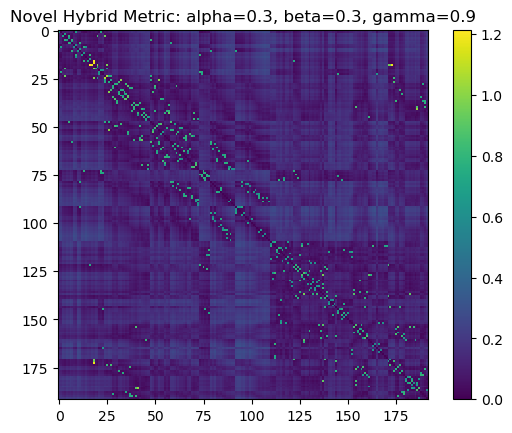

Testing for : alpha=0.3, beta=0.5, gamma=0.5


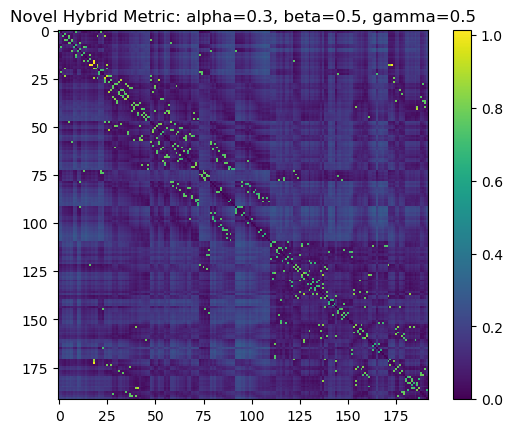

Testing for : alpha=0.3, beta=0.5, gamma=0.7


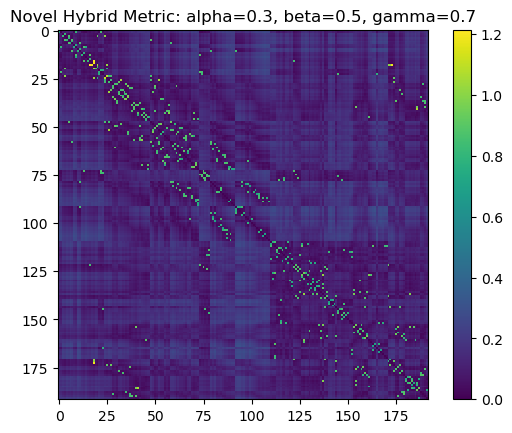

Testing for : alpha=0.3, beta=0.5, gamma=0.9


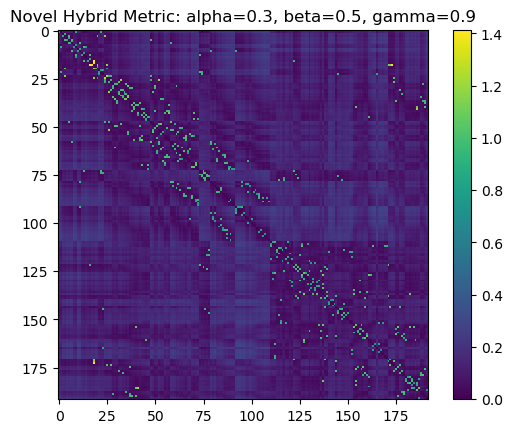

Testing for : alpha=0.5, beta=0.1, gamma=0.5


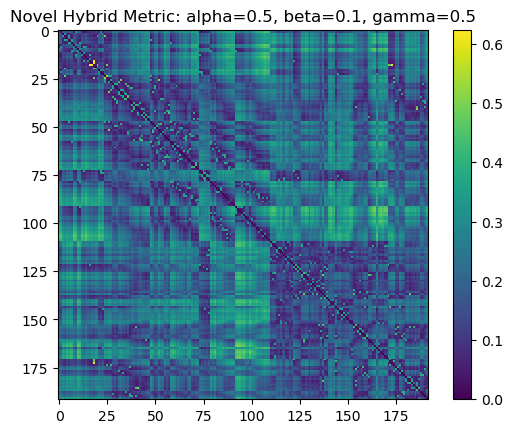

Testing for : alpha=0.5, beta=0.1, gamma=0.7


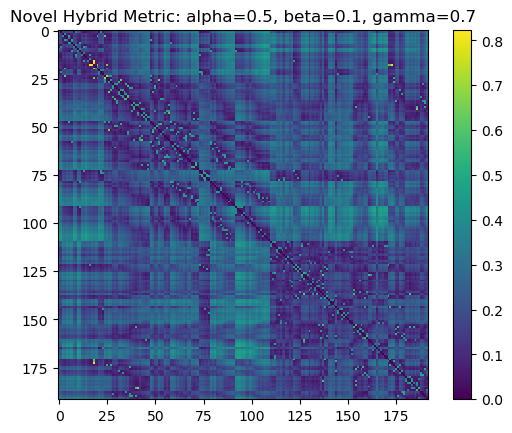

Testing for : alpha=0.5, beta=0.1, gamma=0.9


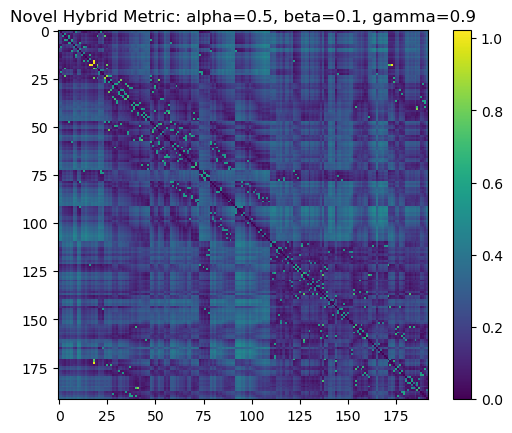

Testing for : alpha=0.5, beta=0.3, gamma=0.5


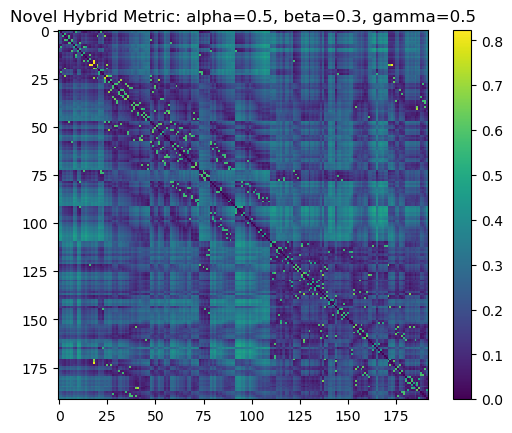

Testing for : alpha=0.5, beta=0.3, gamma=0.7


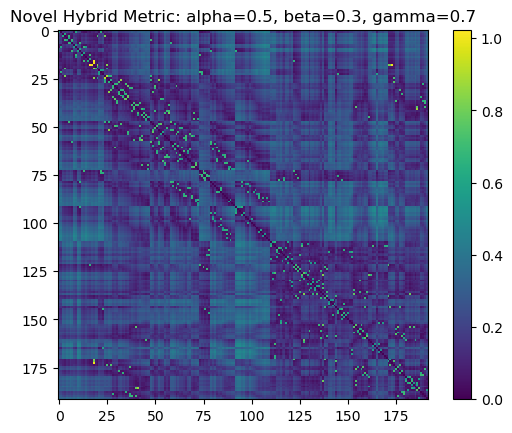

Testing for : alpha=0.5, beta=0.3, gamma=0.9


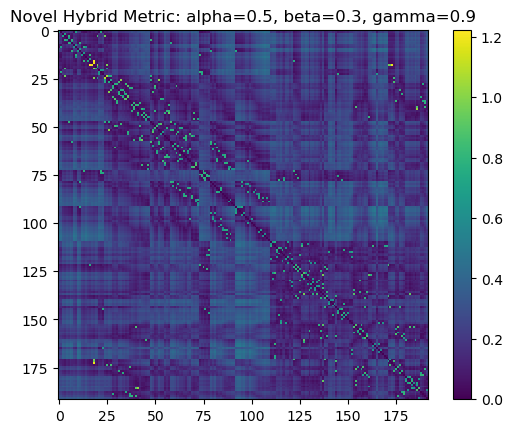

Testing for : alpha=0.5, beta=0.5, gamma=0.5


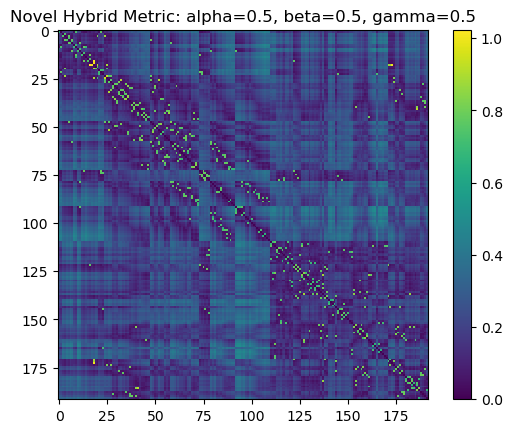

Testing for : alpha=0.5, beta=0.5, gamma=0.7


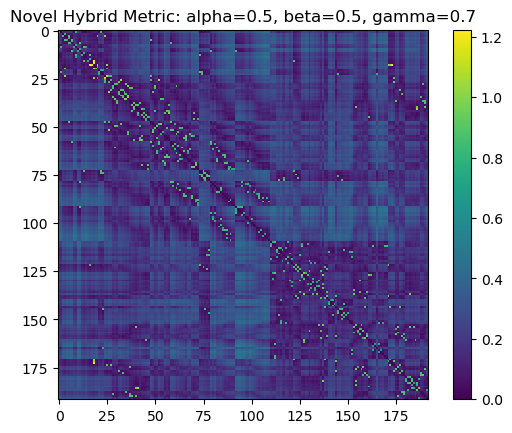

Testing for : alpha=0.5, beta=0.5, gamma=0.9


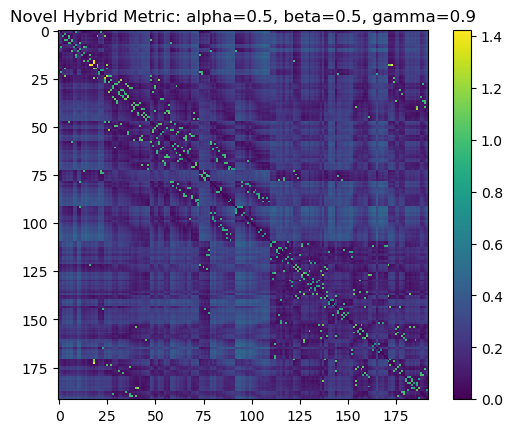

Testing for : alpha=0.7, beta=0.1, gamma=0.5


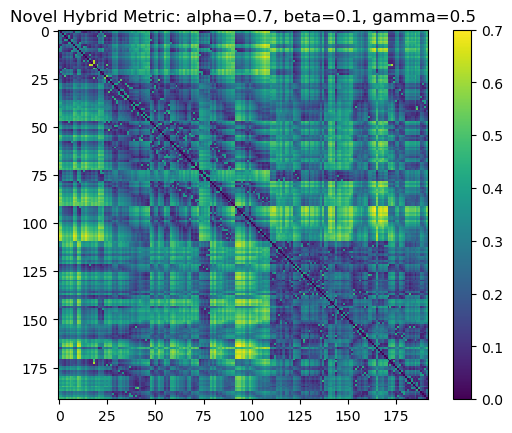

Testing for : alpha=0.7, beta=0.1, gamma=0.7


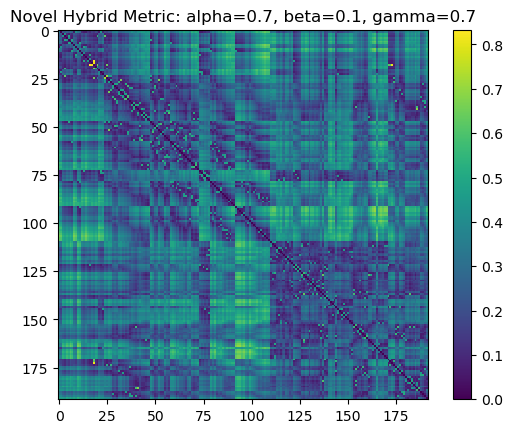

Testing for : alpha=0.7, beta=0.1, gamma=0.9


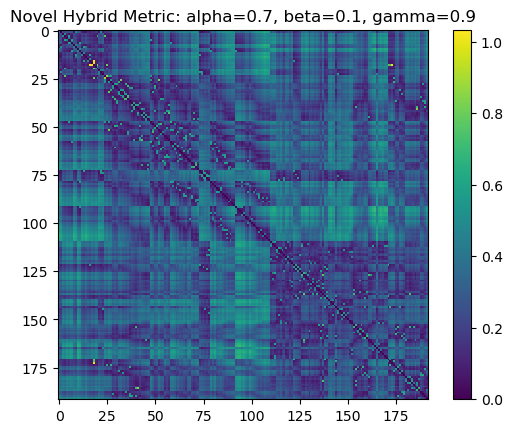

Testing for : alpha=0.7, beta=0.3, gamma=0.5


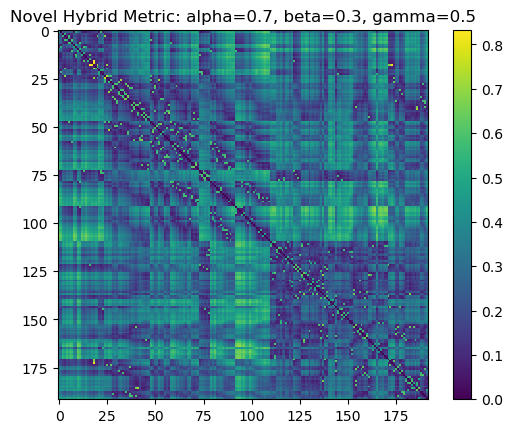

Testing for : alpha=0.7, beta=0.3, gamma=0.7


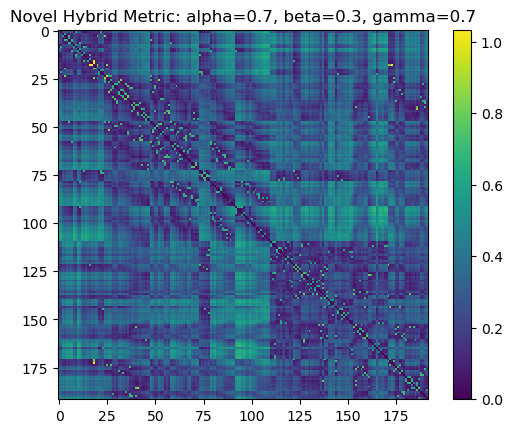

Testing for : alpha=0.7, beta=0.3, gamma=0.9


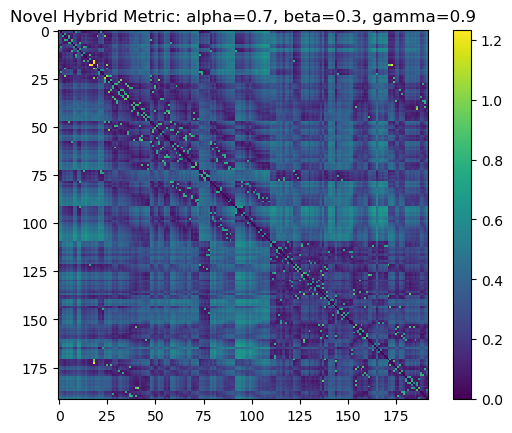

Testing for : alpha=0.7, beta=0.5, gamma=0.5


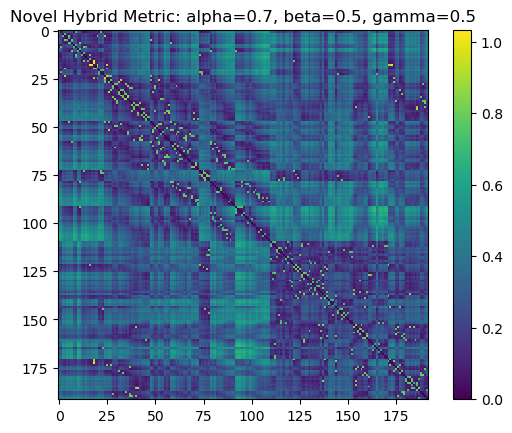

Testing for : alpha=0.7, beta=0.5, gamma=0.7


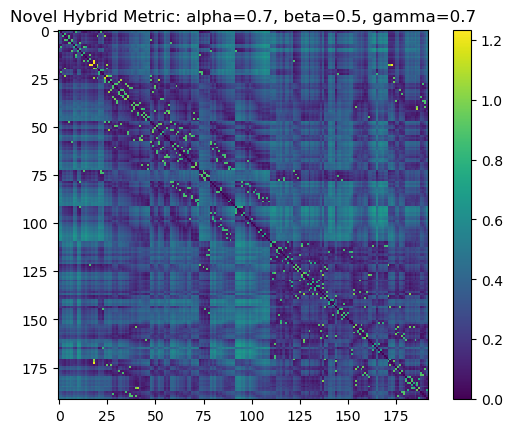

Testing for : alpha=0.7, beta=0.5, gamma=0.9


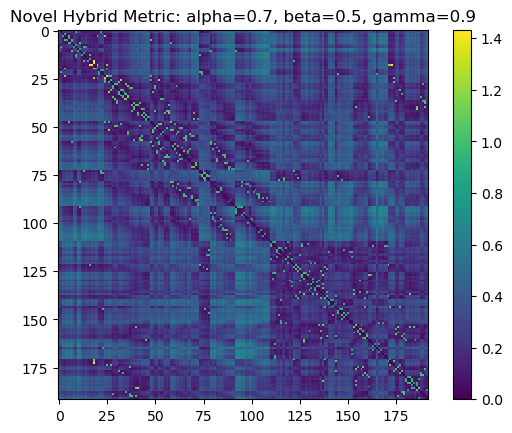

In [202]:
# Naturally ,We need to initialize the parameters grid for alpha, beta, and gamma as follow :
alpha_values = [0.3, 0.5, 0.7]
beta_values = [0.1, 0.3, 0.5]
gamma_values = [0.5, 0.7, 0.9]

print(D_sp)# D_sp: represents the shortest path distance matrix
print(C) # C: represent the communicability distance matrix

# To automate the computation we define a function to compute the hybrid distances for every set of grid value:


#---------------------------definition of our function----------------------------------
def H_metric(alpha, beta, gamma, A, C, D_sp):
    # we then normalize each distance matrix by dividing by its max value
    A_norm = A / np.max(A)
    C_norm = C / np.max(C)
    D_sp_norm = D_sp / np.max(D_sp)
    #print(A_norm)
    # Compute the hybrid distance matrix
    return alpha*D_sp_norm + beta*A_norm + gamma * C_norm 
#-------------------------end---definition of our function----------------------------------

# Then for every set of values of the parameter grid we compute the hybrid metric and plot the 
# corresponding heatmap
for alpha in alpha_values:
    for beta in beta_values:
        for gamma in gamma_values:
            print(f"Testing for : alpha={alpha}, beta={beta}, gamma={gamma}")
            H = H_metric(alpha, beta, gamma, A, C, D_sp)
            plt.figure()
            plt.imshow(H, cmap='viridis', interpolation='none')
            plt.colorbar()
            plt.title(f"Novel Hybrid Metric: alpha={alpha}, beta={beta}, gamma={gamma}")
            plt.savefig(f"{pic}Novel Hybrid Metric: alpha={alpha}, beta={beta}, gamma={gamma}.png")
            plt.show()

# II. Task compare distribution of nodes in the shortest path 

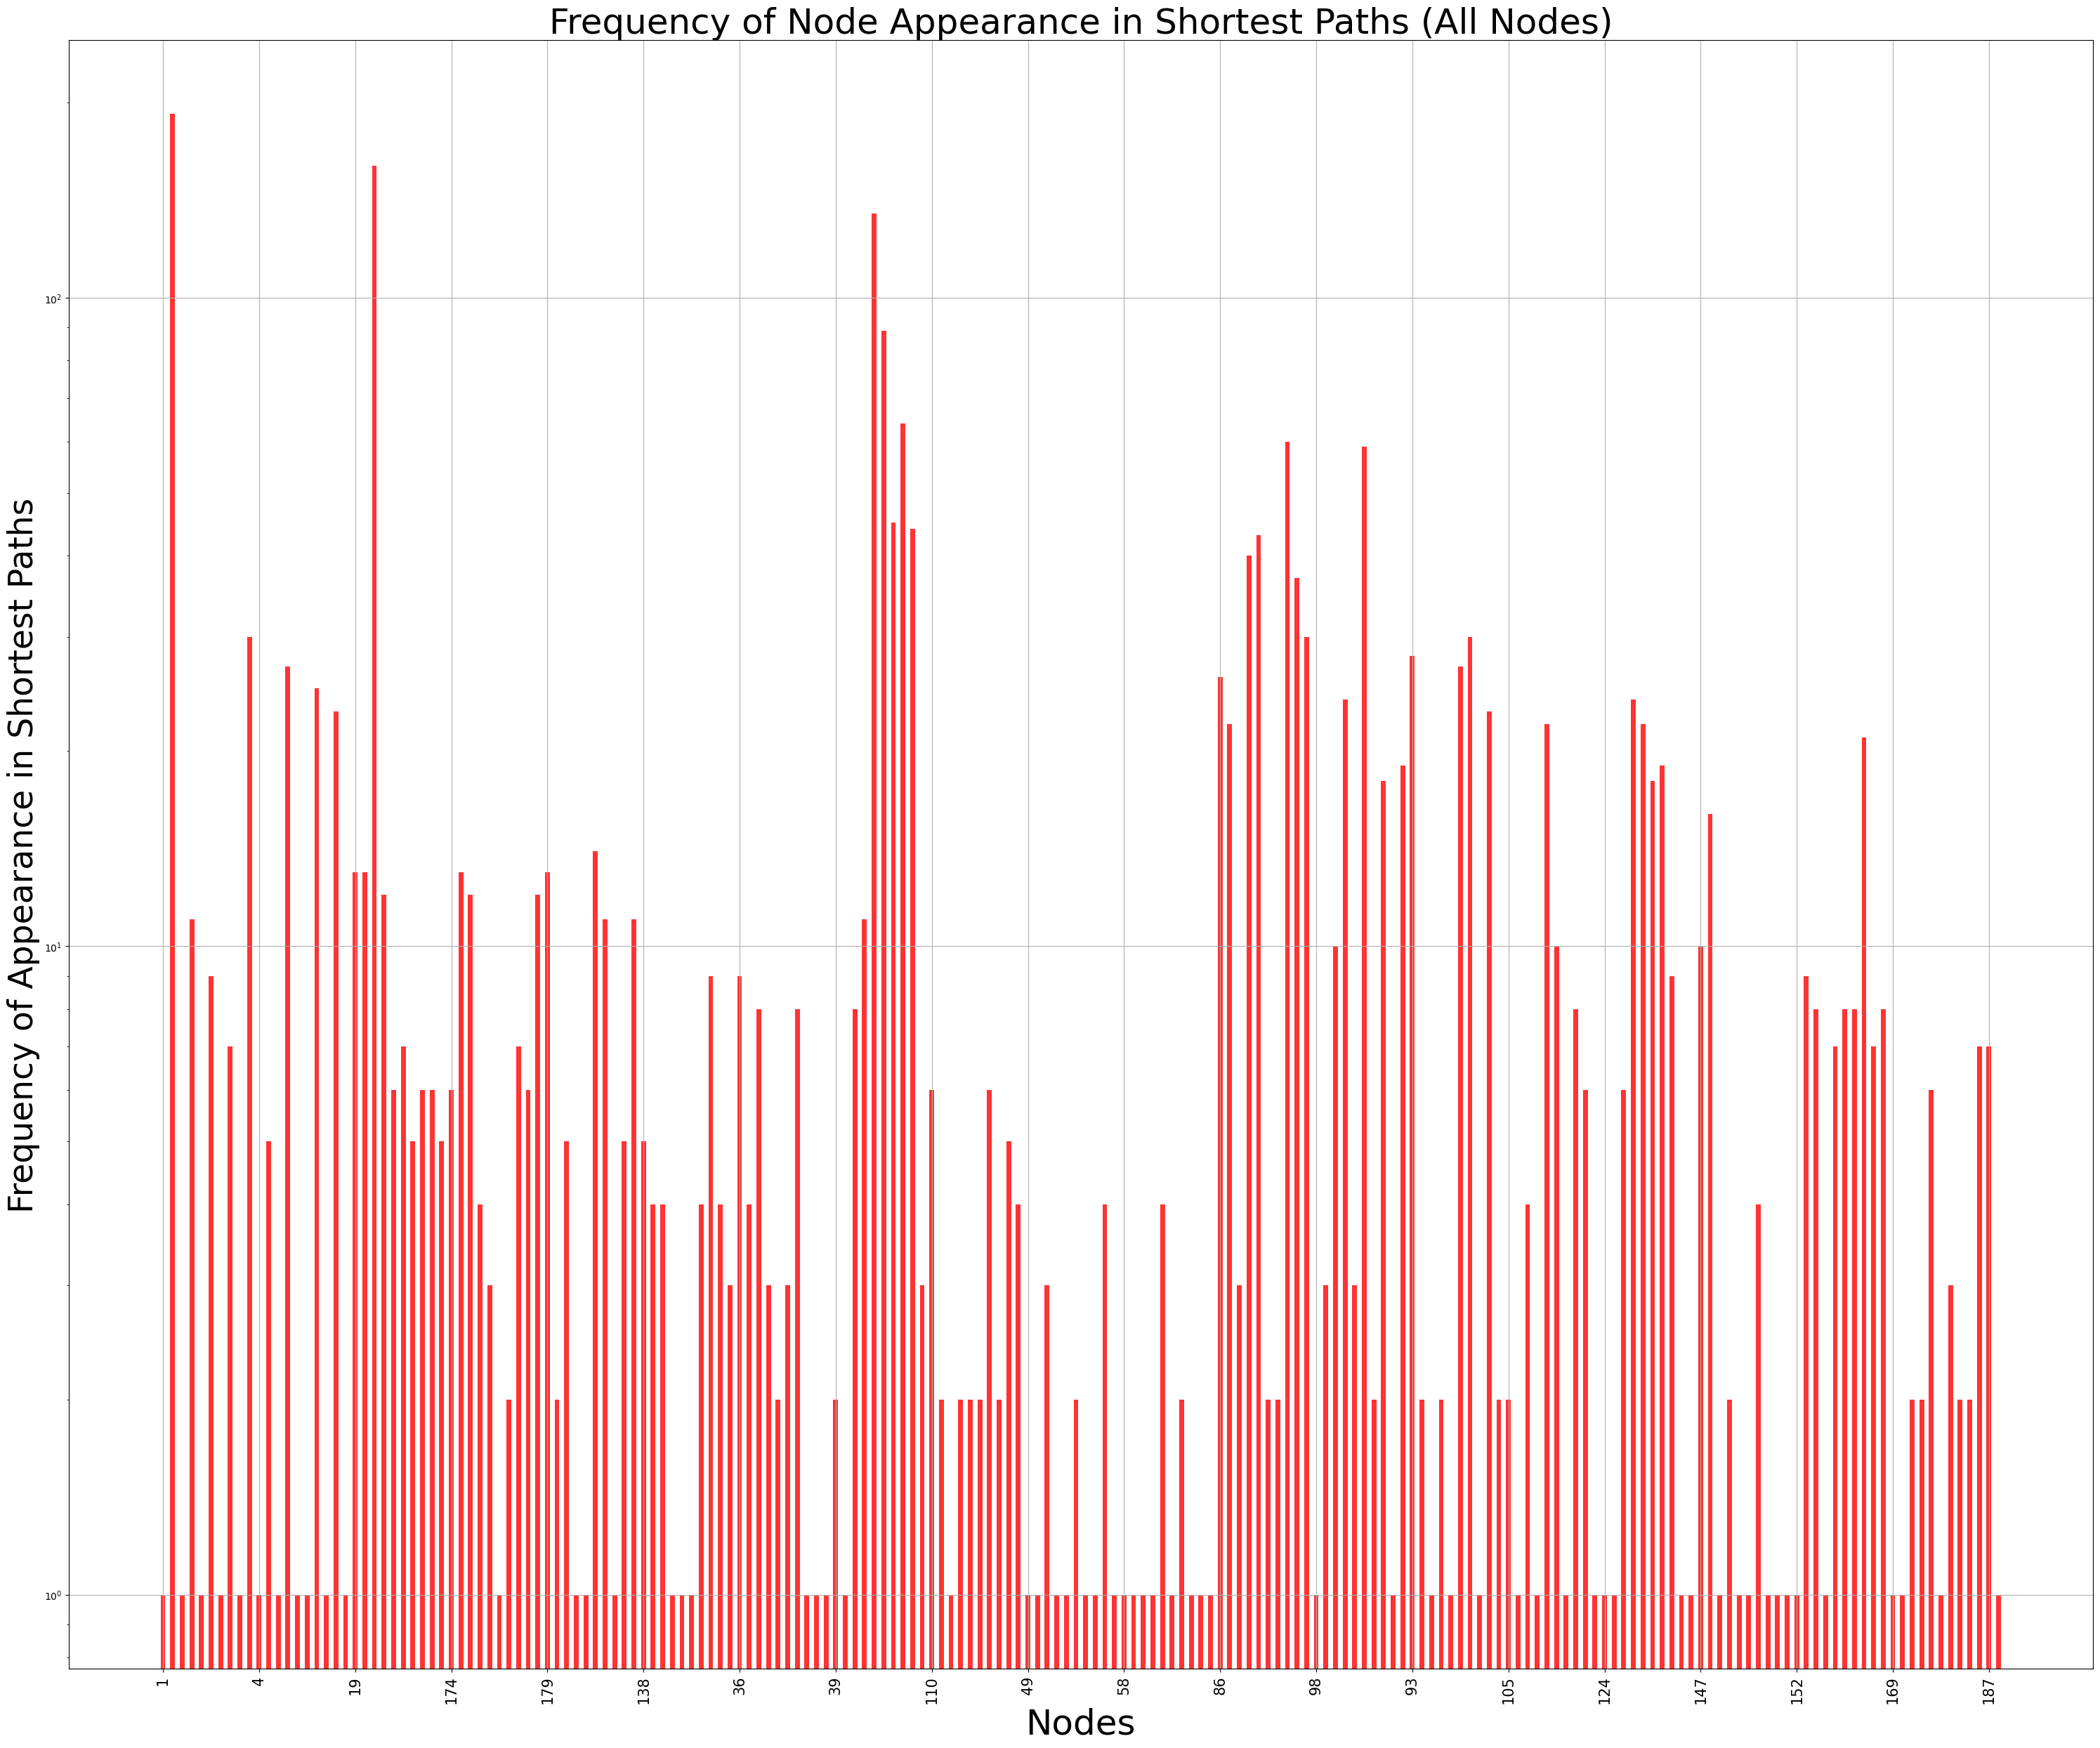

In [207]:
# Example dictionary (result of a Dijkstra algorithm)
# Format: {end_node: [list of nodes in the shortest path from source to end_node]}

# Initialize a list to store all nodes from the paths
all_nodes_in_paths = []

# Collect all nodes from the values (which are paths)
for path in Sorted_Cpq.values():
    all_nodes_in_paths.extend(path)  # Append all nodes in each path to the list

# Count the frequency of each node across all paths
node_frequencies = Counter(all_nodes_in_paths)

# Separate the node ids and their corresponding frequencies
nodes = list(node_frequencies.keys())
frequencies = list(node_frequencies.values())

#Option 3: Increase the figure size for all nodes

plt.figure(figsize=(30, 25))  # Increase the figure size for better visibility
plt.bar(nodes, frequencies, color='r', alpha=0.8, width=0.5)  # Adjust the bar width
plt.xlabel('Nodes', fontsize=36)
plt.ylabel('Frequency of Appearance in Shortest Paths', fontsize=34)
plt.title('Frequency of Node Appearance in Shortest Paths (All Nodes)', fontsize=36)

# Rotate x-axis labels further for better readability
plt.xticks(rotation=90, fontsize=15)

# Adjust y-axis to log scale if needed (uncomment if you want log scale)
plt.yscale('log')
# Reduce the number of x-ticks to avoid clutter (e.g., show every 10th node)
plt.xticks(ticks=range(0, len(nodes), 10), labels=nodes[::10], rotation=90)
plt.grid(True)
plt.tight_layout()  # Ensure everything fits within the figure
plt.savefig(f"{pic}Communicabilty-Distribution.png")
plt.show()


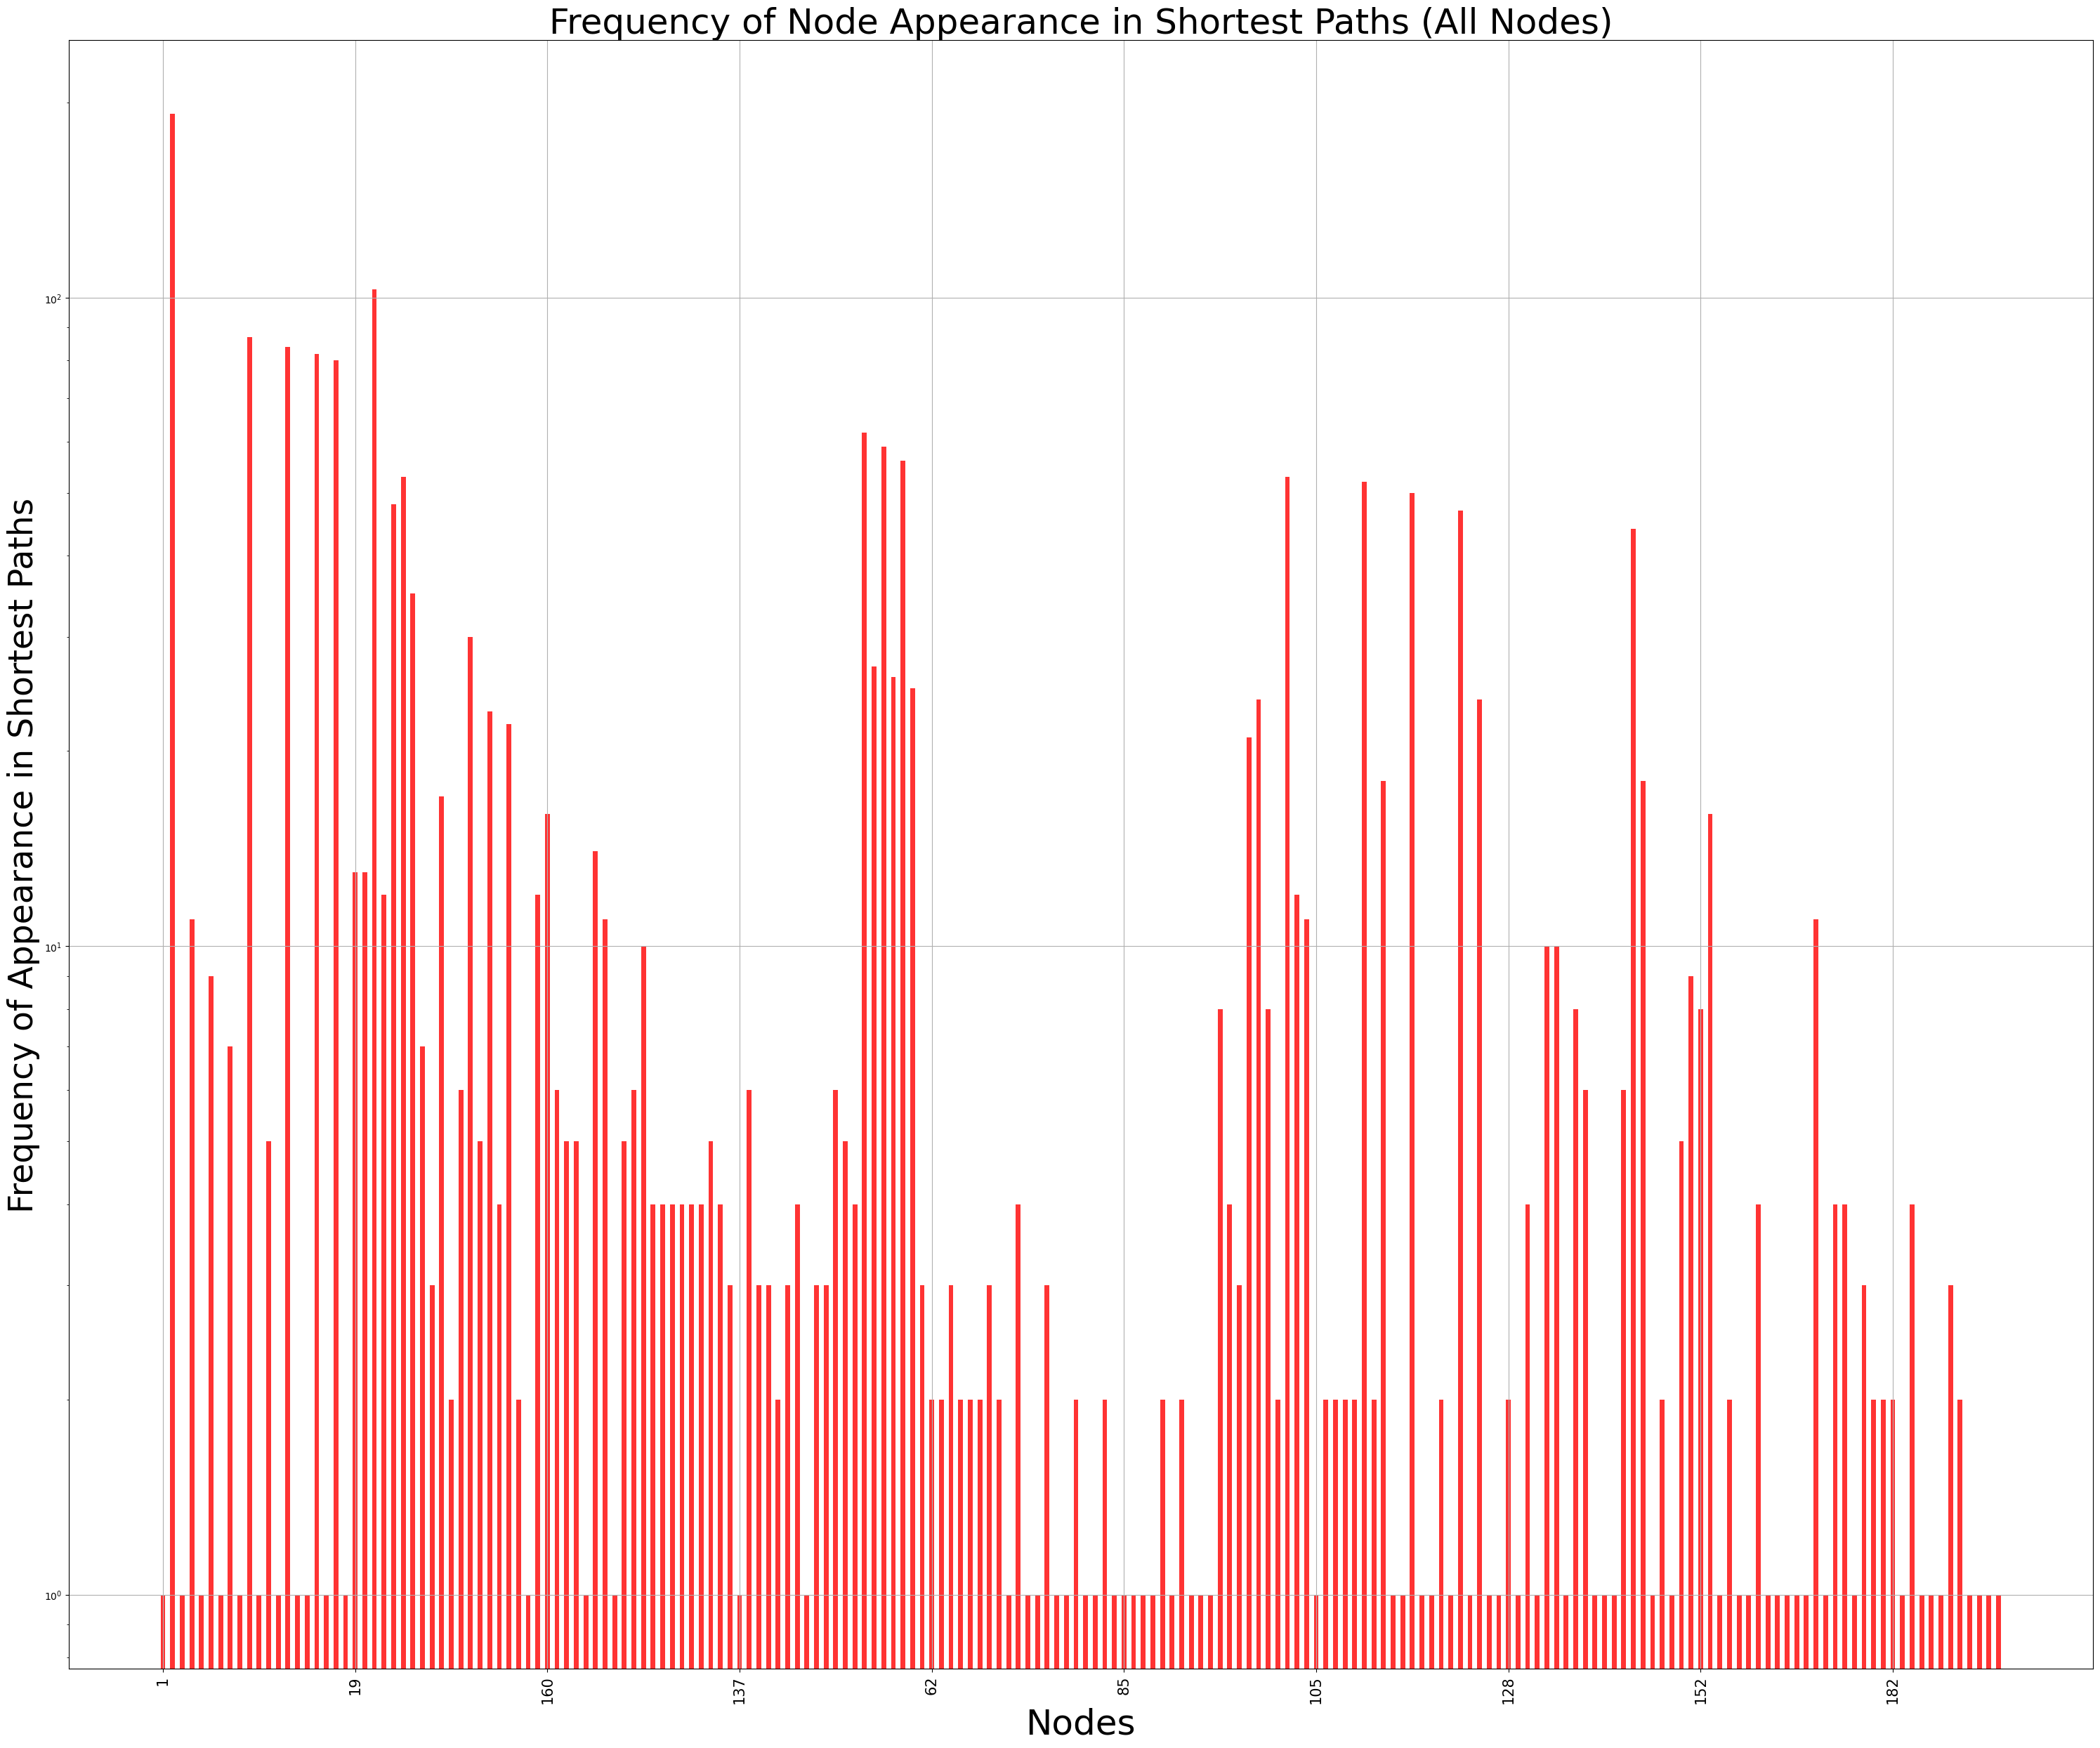

In [208]:
# Initialize a list to store all nodes from the paths
all_nodes_in_paths = []

# Collect all nodes from the values (which are paths)
for path in Sorted_Dpq.values():
    all_nodes_in_paths.extend(path)  # Append all nodes in each path to the list

# Count the frequency of each node across all paths
node_frequencies = Counter(all_nodes_in_paths)

# Separate the node ids and their corresponding frequencies
nodes = list(node_frequencies.keys())
frequencies = list(node_frequencies.values())

#Option 3: Increase the figure size for all nodes
plt.figure(figsize=(30, 25))  # Increase the figure size for better visibility
plt.bar(nodes, frequencies, color='r', alpha=0.8, width=0.5)  # Adjust the bar width
plt.xlabel('Nodes', fontsize=36)
plt.ylabel('Frequency of Appearance in Shortest Paths', fontsize=34)
plt.title('Frequency of Node Appearance in Shortest Paths (All Nodes)', fontsize=36)

# Rotate x-axis labels further for better readability
plt.xticks(rotation=90, fontsize=15)

# Adjust y-axis to log scale if needed (uncomment if you want log scale)
plt.yscale('log')

# Reduce the number of x-ticks to avoid clutter (e.g., show every 10th node)
plt.xticks(ticks=range(0, len(nodes), 20), labels=nodes[::20], rotation=90)
plt.grid(True)
plt.tight_layout()  # Ensure everything fits within the figure
plt.savefig(f"{pic}shortest-path-Distribution.png")
plt.show()

# III. Rewiring Strategy

## Attempt 3

Node 9 has higher frequency in regular (87) than communicability (30).
Node 13 has higher frequency in regular (84) than communicability (27).
Node 16 has higher frequency in regular (82) than communicability (25).
Node 18 has higher frequency in regular (80) than communicability (23).
Node 22 has higher frequency in communicability (160) than regular (103).
Node 24 has higher frequency in regular (48) than communicability (6).
Node 25 has higher frequency in regular (53) than communicability (7).
Node 26 has higher frequency in regular (35) than communicability (5).
Node 27 has higher frequency in regular (7) than communicability (6).
Node 28 has higher frequency in communicability (6) than regular (3).
Node 29 has higher frequency in regular (17) than communicability (5).
Node 30 has higher frequency in communicability (6) than regular (2).
Node 31 has higher frequency in communicability (13) than regular (6).
Node 32 has higher frequency in regular (30) than communicability (12).
No

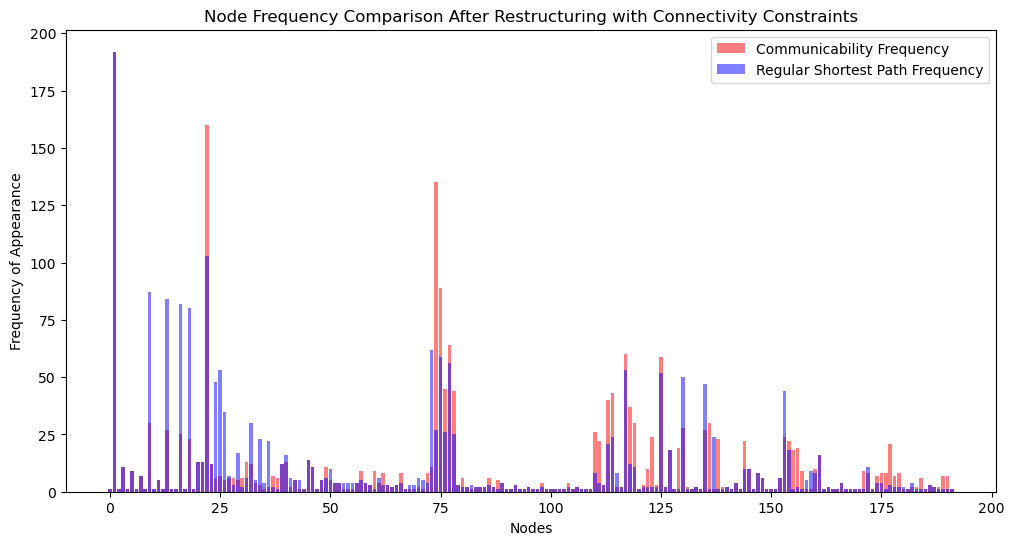

In [209]:
# Function to count node frequencies in the paths
def count_node_frequencies(paths_dict):
    all_nodes = []
    for path in paths_dict.values():
        all_nodes.extend(path)
    return Counter(all_nodes)

# Compute frequencies for both distributions
comm_freq = count_node_frequencies(Sorted_Cpq)
reg_freq = count_node_frequencies(Sorted_Dpq)

# Create a graph for modification purposes
Gmod = nx.Graph()

# Add edges from paths to the graph (representing the original network)
for path in Sorted_Cpq.values():
    nx.add_path(Gmod, path)
for path in Sorted_Dpq.values():
    nx.add_path(Gmod, path)

# Get the original number of edges and nodes
original_num_edges = Gmod.number_of_edges()
original_num_nodes = Gmod.number_of_nodes()

# Ensure that the original graph is connected
assert nx.is_connected(Gmod), "The original graph is not connected!"

# Adjust node degrees based on frequency comparisons
for node in set(comm_freq.keys()).union(set(reg_freq.keys())):
    comm_count = comm_freq.get(node, 0)
    reg_count = reg_freq.get(node, 0)

    # Case 1: Frequency is higher in the communicability distribution
    if comm_count > reg_count:
        diff = comm_count - reg_count
        print(f"Node {node} has higher frequency in communicability ({comm_count}) than regular ({reg_count}).")

        # We attempt to reroute some paths to other nearby nodes
        neighbors = list(Gmod.neighbors(node))
        for _ in range(diff):
            if len(neighbors) > 0:
                # Shift some connections to nearby nodes without disconnecting
                neighbor = neighbors.pop(0)
                if Gmod.has_edge(node, neighbor):
                    Gmod.remove_edge(node, neighbor)
                    # Check if removing the edge disconnects the graph
                    if not nx.is_connected(Gmod):
                        # Revert the removal if it disconnects the graph
                        Gmod.add_edge(node, neighbor)
                    else:
                        # Add the edge to a new node if possible
                        new_neighbor = max(Gmod.nodes()) + 1 if neighbor not in Gmod else neighbor
                        Gmod.add_edge(node, new_neighbor)

    # Case 2: Frequency is higher in the regular shortest path distribution
    elif reg_count > comm_count:
        diff = reg_count - comm_count
        print(f"Node {node} has higher frequency in regular ({reg_count}) than communicability ({comm_count}).")

        # Shift some connections to/from this node to balance
        neighbors = list(Gmod.neighbors(node))
        for _ in range(diff):
            if len(neighbors) > 0:
                neighbor = neighbors.pop(0)
                if Gmod.has_edge(node, neighbor):
                    Gmod.remove_edge(node, neighbor)
                    # Check if removing the edge disconnects the graph
                    if not nx.is_connected(Gmod):
                        # Revert the removal if it disconnects the graph
                        Gmod.add_edge(node, neighbor)
                    else:
                        # Add the edge to a new node if possible
                        new_neighbor = max(Gmod.nodes()) + 1 if neighbor not in Gmod else neighbor
                        Gmod.add_edge(node, new_neighbor)

# Ensure no new edges or nodes are added, and the graph remains connected
assert nx.is_connected(Gmod), "The graph became disconnected!"
assert Gmod.number_of_edges() <= original_num_edges, "More edges were added than allowed!"
assert Gmod.number_of_nodes() <= original_num_nodes, "More nodes were added than allowed!"

# Recompute the frequencies after modification
new_comm_freq = count_node_frequencies(Sorted_Cpq)
new_reg_freq = count_node_frequencies(Sorted_Dpq)

# Plot updated frequencies
nodes = sorted(set(new_comm_freq.keys()).union(set(new_reg_freq.keys())))
comm_freq_values = [new_comm_freq.get(node, 0) for node in nodes]
reg_freq_values = [new_reg_freq.get(node, 0) for node in nodes]

# Plotting the updated distributions
plt.figure(figsize=(12, 6))
plt.bar(nodes, comm_freq_values, alpha=0.5, color='r', label="Communicability Frequency")
plt.bar(nodes, reg_freq_values, alpha=0.5, color='b', label="Regular Shortest Path Frequency")
plt.xlabel('Nodes')
plt.ylabel('Frequency of Appearance')
plt.title('Node Frequency Comparison After Restructuring with Connectivity Constraints')
plt.legend()
plt.savefig(f"{pic}Matching-Distributions.png")
plt.show()


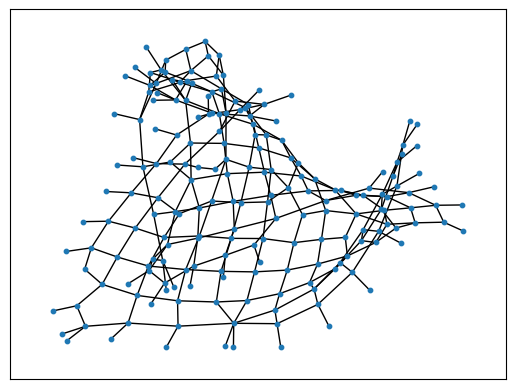

In [150]:
nx.draw_networkx(G,with_labels=False,node_size=10)
plt.axis('on')
# plt.savefig("Final_Structure_of_The_Network.png") 
plt.show()

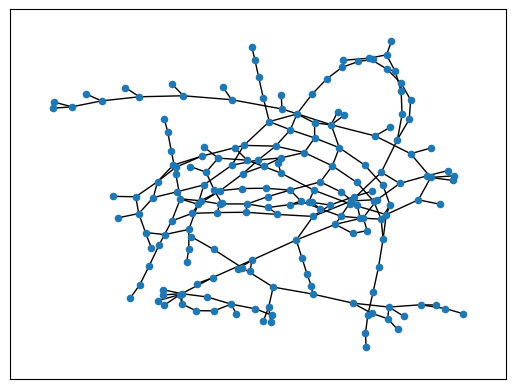

In [210]:
nx.draw_networkx(Gmod,with_labels=False,node_size=20)
plt.axis('on')
plt.savefig(f"{pic}Final-Structure-of-The-rewired-Network.png") 
plt.show()

In [215]:
Amod=nx.to_numpy_array(Gmod)
Gmod=nx.from_numpy_array(Amod)
print(Amod)

[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


In [216]:
A=nx.to_numpy_array(G)
print(A)

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [217]:
check=0
for i in range(len(A)): 
    for j in range(len(Amod)):
        if A[i,j]==Amod[i,j]:
            check+=1
print(check)

35934


In [218]:
print(f"{(1-(check/(len(A)**2)))*100}%")

2.522786458333337%


# V. Check The communicabiltiy in the new Rewired Network 

[[3.26569795e+00 1.64457696e+00 2.33790460e+00 ... 1.01085448e-08
  7.61797158e-10 5.32803530e-11]
 [1.64457696e+00 1.64823565e+00 8.04287384e-01 ... 7.58306461e-10
  5.32803530e-11 3.49069786e-12]
 [2.33790460e+00 8.04287384e-01 4.00142966e+00 ... 7.77972633e-10
  5.44924186e-11 3.56094628e-12]
 ...
 [1.01085448e-08 7.58306461e-10 7.77972633e-10 ... 3.33222151e+00
  1.86060818e+00 6.97783689e-01]
 [7.61797158e-10 5.32803530e-11 5.44924186e-11 ... 1.86060818e+00
  2.29013882e+00 1.38893311e+00]
 [5.32803530e-11 3.49069786e-12 3.56094628e-12 ... 6.97783689e-01
  1.38893311e+00 1.59235513e+00]]
[[0.         1.62477969 2.5913184  ... 6.59791944 5.55583678 4.85805309]
 [1.62477969 0.         4.04109054 ... 4.98045716 3.93837447 3.24059079]
 [2.5913184  4.04109054 0.         ... 7.33365116 6.29156848 5.59378479]
 ...
 [6.59791944 4.98045716 7.33365116 ... 0.         1.90114398 3.52900926]
 [5.55583678 3.93837447 6.29156848 ... 1.90114398 0.         1.10462773]
 [4.85805309 3.24059079 5.5937

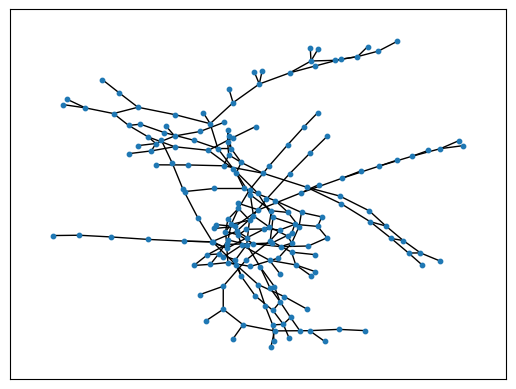

(192,)


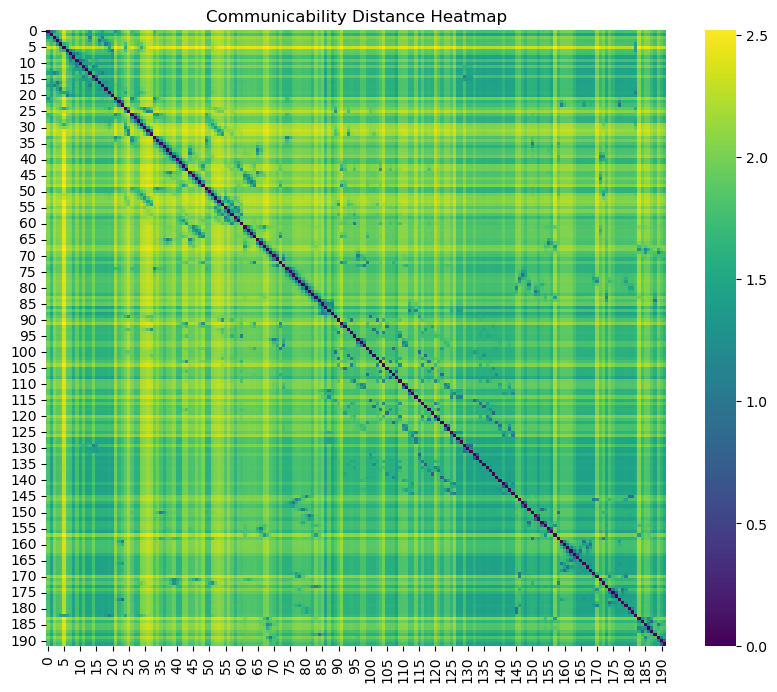

In [222]:
Bmod=sp.linalg.expm(Amod)#compute the communicability Matrix Function
print(Bmod)
Dmod=np.zeros((len(Bmod),len(Bmod)))
for i in range(len(Bmod)):
    for j in range(len(Bmod)):
        Dmod[i,j]=Bmod[i,i]+Bmod[j,j]-2*Bmod[i,j]
print(Dmod) # D is the communicability matrix of the graph 
print(Bmod)
Cmod=Amod*Dmod# is the communicability distance matrix
print(Cmod)
G11=nx.from_numpy_array(Cmod)
nx.draw_networkx(G11,with_labels=False,node_size=10)
plt.savefig(f"{pic}Communicability_of_The_New_Structure_of_The_Network.png") 
plt.show()
print(np.shape(G11))
# Heatmap for communicability distance matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(np.log(Dmod+1), cmap='viridis')
plt.title("Communicability Distance Heatmap")
plt.savefig(f"{pic}Communicability_Distance_Heatmap_rewired_network.png")
plt.show()

{0: [1, 0], 1: [1], 2: [1, 0, 2], 3: [1, 0, 2, 3], 4: [1, 0, 2, 3, 4], 5: [1, 0, 2, 3, 4, 5], 6: [1, 0, 2, 3, 4, 5, 6], 7: [1, 0, 2, 3, 4, 5, 6, 7], 8: [1, 0, 2, 3, 4, 5, 6, 7, 8], 9: [1, 0, 2, 3, 4, 5, 6, 7, 9], 10: [1, 0, 2, 3, 4, 5, 6, 7, 9, 10], 11: [1, 0, 2, 3, 4, 5, 6, 7, 9, 11], 12: [1, 0, 2, 3, 4, 5, 6, 7, 9, 11, 12], 13: [1, 0, 2, 13], 14: [1, 0, 2, 3, 4, 5, 6, 7, 9, 11, 14], 15: [1, 0, 2, 3, 4, 5, 6, 7, 9, 11, 14, 15], 16: [1, 0, 2, 3, 16], 17: [1, 0, 2, 17], 18: [1, 0, 2, 3, 4, 18], 19: [1, 0, 2, 3, 4, 5, 19], 20: [1, 0, 2, 3, 4, 5, 6, 20], 21: [1, 0, 21], 22: [1, 0, 21, 22], 23: [1, 0, 21, 22, 23], 24: [1, 0, 2, 3, 4, 5, 24], 25: [1, 0, 2, 3, 4, 5, 24, 25], 26: [1, 0, 21, 26], 27: [1, 0, 21, 26, 27], 28: [1, 0, 21, 26, 27, 28], 29: [1, 0, 21, 26, 27, 28, 29], 30: [1, 0, 21, 26, 27, 28, 29, 30], 31: [1, 0, 21, 26, 27, 28, 29, 30, 31], 32: [1, 0, 21, 26, 27, 28, 29, 30, 31, 32], 33: [1, 0, 21, 33], 34: [1, 0, 21, 26, 34], 35: [1, 0, 21, 26, 34, 35], 36: [1, 0, 21, 26, 34, 35,

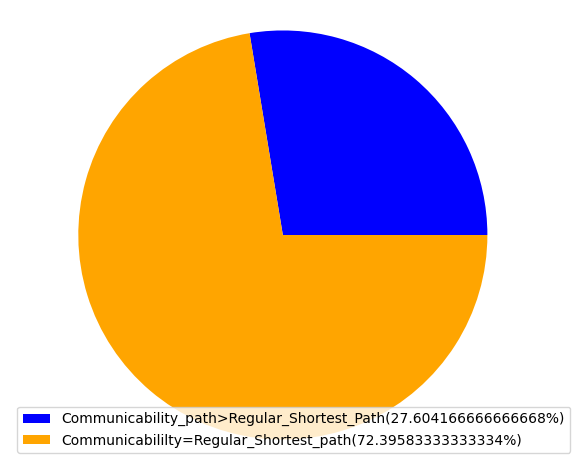

In [220]:
source_node = 1  
#-------------------------------------------------------------------------------------------------------
#This code below is generating the communicability shortest distance 
shortest_paths_dijkstra1mod = nx.shortest_path(G11, source=source_node, weight='weight')
#-------------------------------------------------------------------------------------------------------
# We can easily see that by computing the above code the dictionnary keys are not sorted
#---------------------------------dictionary key sorting attempts--------------------------------------------------------------------
Cpqmod=list( shortest_paths_dijkstra1mod.keys() )
Cpqmod.sort()
# print(Cpq)
Sorted_Cpqmod={i:shortest_paths_dijkstra1mod[i] for i in Cpqmod} # 
print(Sorted_Cpqmod)
#-------------------------------------------------------------------------------------------------------
shortest_paths_dijkstra2mod = nx.shortest_path(Gmod, source=source_node, weight='weight')
Dpqmod=list( shortest_paths_dijkstra2mod.keys() )
Dpqmod.sort()
# print(Dpq)
Sorted_Dpqmod={i:shortest_paths_dijkstra2mod[i] for i in Dpqmod}
# print(Sorted_Dpq)

len(Sorted_Cpqmod)==len(Sorted_Dpqmod)
A1mod=Sorted_Cpqmod.keys()
# print(A1)
A2mod=Sorted_Dpq.keys()
# print(A2)
A1mod==A2mod
A1mod_values=Sorted_Cpqmod.values()#

A2mod_values=Sorted_Dpqmod.values() #shortest communicability path 
# print(list(A2_values))


A22mod=[len(i) for i in list(A2mod_values)]
A11mod=[len(i) for i in list(A1mod_values)] # It is the list of the paths lengths in Cpq_values ie associated to a given node
# print(len(A11))

indxmod=[]
for i in range(len(A11mod)):
    if A11mod[i]!=A22mod[i] :
        indxmod.append(i)
print(len(indxmod))
compmod=[]
CpqA11mod=[] #
DpqA22mod=[]
#creating now list that stores values when com_SP>Regularshortest(or else) and when they are equal
Cpq_greatmod=[]
Cpq_eq_Spmod=[]
for i in indxmod :
    CpqA11mod.append(A11mod[i])# communicability distance for the indices where Cpq differ from Dpq 
    DpqA22mod.append(A22mod[i])# regular shortest path the indices where Cpq differ from Dpq
    compmod.append((A11mod[i],A22mod[i]))
print(len(DpqA22mod))
# print(comp)
#creating now list that stores values when com_SP>Regularshortest(or else) and when they are equal
Cpq_greatmod=[]
Spq_greatmod=[]
Cpq_eq_Spmod=[]
for i in range(len(A11mod)):
    if A11mod[i]>A22mod[i]:
        Cpq_greatmod.append(A11mod[i])
    elif A11mod[i]<A22mod[i]:
        Spq_greatmod.append(A22mod[i])
    else :
        Cpq_eq_Spmod.append(A11mod[i])
print( len(Cpq_greatmod),len(Cpq_eq_Spmod) )

# The slices will be ordered and plotted counter-clockwise.
P1mod=(len(Cpq_greatmod)/len(A11mod))*100
P2mod=(len(Cpq_eq_Spmod)/len(A11mod))*100
labels = [f'Communicability_path>Regular_Shortest_Path({P1mod}%)', f'Communicabililty=Regular_Shortest_path({P2mod}%)']
sizes = [P1mod,P2mod]
colors = ['blue', 'orange']
patches, texts = plt.pie(sizes, colors=colors, startangle=0)
plt.legend(patches, labels,loc='best')
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.tight_layout()
plt.savefig(f"{pic}Shorest_path_comparison_rewired-network.png")
plt.show()

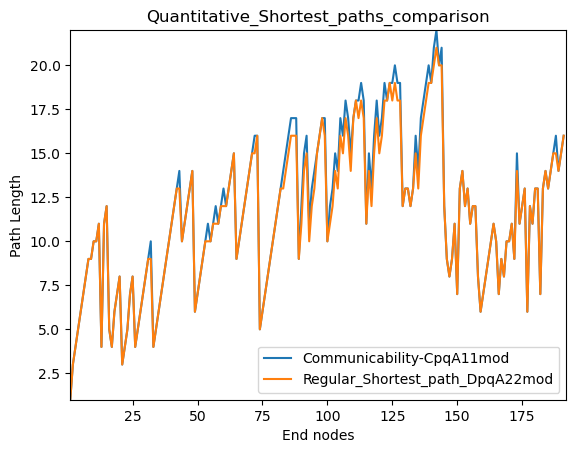

In [226]:
plt.plot(range(len(A11mod)), A11mod, label = "Communicability-CpqA11mod")
plt.plot(range(len(A11mod)), A22mod, label = "Regular_Shortest_path_DpqA22mod")
plt.xlim(1,len(A11mod))
plt.ylim(1,max(A11mod))
plt.xlabel('End nodes')
plt.ylabel('Path Length')
plt.title('Quantitative_Shortest_paths_comparison')
plt.legend()
# plt.savefig("Quantitative_Shorest_paths_comparison_Plot.png")
plt.savefig(f"{pic}Qt-Shorest_path_comparison_rewired-network.png")
plt.show()
# A11